In [4]:
'''
Credit goes to Mr. Georgio for creating the very helpful modules used in this file.
'''

'\nCredit goes to Mr. Georgio for creating the very helpful modules used in this file.\n'

### Imports and table functions

In [5]:
from pyscf import gto,scf, cc
import numpy as np
import pyscf
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import basis_set_exchange as bse
from FcMole import FcM, FcM_like
from AP_class import APDFT_perturbator as AP
from alch_deriv import first_deriv_elec,DeltaV
from scipy.optimize import curve_fit
import numpy.fft as fft
from scipy.signal import find_peaks
from scipy.stats import pearsonr

In [15]:
def generate_table(data):
    # Determine the maximum width of each column
    column_widths = [max(len(str(row[i])) for row in data) for i in range(len(data[0]))]

    # Generate the table header
    table = generate_table_row(data[0], column_widths)
    table += generate_table_row(['-' * width for width in column_widths], column_widths)

    # Generate the table rows
    for row in data[1:]:
        table += generate_table_row(row, column_widths)

    return table

def generate_table_row(row_data, column_widths):
    row = '|'
    for i, item in enumerate(row_data):
        row += f' {str(item):{column_widths[i]}} |'
    row += '\n'
    return row

def get_free_energy(mol_i, n):
    return -0.5*np.sum(mol_i.atom_charges()**n)

def new_mol(mol_i,n,l_i, l_f, left_right = None):
    '''Returns a new molecule, converged object, 
    total electronic energy and free energy of the new molecule
    at the l_i, l_f perturbation with n as the non linearity parameter.'''
    
    if left_right == 'L':
        mol = FcM_like(mol_i,fcs=[[1,2],[-l_i,l_f]])
    
    else:
        mol = FcM_like(mol_i,fcs=[[0,1],[-l_i,l_f]])
 
    mf_mol=scf.RKS(mol)
    mf_mol.xc="PBE0"
    mf_mol.verbose = 0
    Te_mol=mf_mol.scf(dm0=mf_mol.init_guess_by_1e())
    elec_energy = round(mf_mol.energy_elec()[0],3)
    
    return [mol, mf_mol, elec_energy, get_free_energy(mol,n)]

def d_Z_lambda(mol_i, mol_f,n,lam):
    Z_i = np.array(mol_i.atom_charges())
    Z_f = np.array(mol_f.atom_charges())
    num = (1/n)* (Z_f**n - Z_i**n)
    den = ((Z_i**n) + lam*(Z_f**n - Z_i**n))**(1 - 1/n)
    return num / den

def Z_diff(mol_i, mol_f):
    Z_i = np.array(mol_i.atom_charges())
    Z_f = np.array(mol_f.atom_charges())
    return Z_f - Z_i

def AG(mf,sites=[0,1]):
    grads=[]
    for site in sites:
        grads.append(first_deriv_elec(mf,DeltaV(mf.mol,[[site],[1]])))
    return np.array(grads)

def get_pred(mol_i,AG_i, n,e_i,l_i,l_f):
    '''Returns the linear Z and non linear Z prediction 
    from mol_i using its alchemical grad and energy
    at specific perturbation l_i, l_f at the individual atoms
    
    Caution: l_i = l_f to increase and decrease nuclear charge by same amount in 2 atoms.
    Observe the negative sign.
    '''
    
    mol = FcM_like(mol_i,fcs=[-l_i,l_f])
    print(np.dot(Z_diff(mol_i,mol), AG_i))
    return np.round([e_i + np.dot(Z_diff(mol_i,mol), AG_i),e_i + np.dot(d_Z_lambda(mol_i,mol,n,0), AG_i)],3) 

In [7]:
'''wrapper function for generating data'''
def get_symmetric_change_data(min_lam,max_lam, gen=False):
    if gen:
        frac_energies = []
        free_energies = []
        i = min_lam
        while round(i,3) <= max_lam:
            mol_props = new_mol(NN,7/3, i,i)
            e_mol = mol_props[2]
            free_e = mol_props[3]
            frac_energies.append(e_mol)
            free_energies.append(free_e)
            i  += 0.1
        frac_energies = np.array(frac_energies)
        free_energies = np.array(free_energies)
        np.savetxt(f"data/dft_0_to_{max_lam}.csv",[frac_energies,free_energies])
        
    return np.loadtxt(f'data/dft_0_to_{max_lam}.csv') 
    
def get_asymmetric_change_data(min_lam,max_lam, gen=False):
    if gen:
        R_NN = gto.M(atom= f"N 0 0 0; N 0 0 {d}; H 0 0 {d+s}",unit="Bohr",charge=1,basis='unc-ccpvdz')
        L_NN = gto.M(atom= f"H 0 0 {-s}; N 0 0 0; N 0 0 {d}",unit="Bohr",charge=1,basis='unc-ccpvdz')
        # can protonate in the nearby atom and the far atom
        R_atom_p = []
        L_atom_p = []
        i = min_lam
        
        while round(i,3) <= max_lam:
            mol_props_R = new_mol(R_NN,7/3, i,i,left_right='R')
            e_mol_R = mol_props_R[2]
            R_atom_p.append(e_mol_R)
            
            mol_props_L = new_mol(L_NN,7/3, i,i,left_right='L')
            e_mol_L = mol_props_L[2]
            L_atom_p.append(e_mol_L)
            
            i  += 0.1
        np.savetxt(f"data/prot_0_to_{max_lam}.csv",[R_atom_p,L_atom_p])
    
    return np.loadtxt(f'data/prot_0_to_{max_lam}.csv')

def gen_data(mol,AG,n,e_mol,l_i, l_f):
    l_pre = []
    nl_pre = []
    for i in np.linspace(l_i,l_f, steps + 1):
        pre = get_pred(mol, AG,n, e_mol, i,i)
        l_pre.append(pre[0])
        nl_pre.append(pre[1])
    return np.array(l_pre), np.array(nl_pre)

In [8]:
'''Stat functions'''
# least chi squared function
def chi_sq(y,y_pred):
    return np.sum((y-y_pred)**2)

# Rootmean square error
def rmse(y,y_pred):
    return np.sqrt(np.sum((y-y_pred)**2)/len(y))

# max error
def max_error(y,y_pred):
    return np.max(np.abs(y-y_pred))

# mean absolute error
def mae(y,y_pred):
    return np.sum(np.abs(y-y_pred))/len(y)

# standard deviation
def std(y,y_pred):
    return np.sqrt(np.sum((y-y_pred)**2)/(len(y)-1))


In [9]:
'''Fitting functions'''
def quad_fit(x, a, b, c):
    return a*(x-b)**2 + c

def lin_fit(x,m,c):
    return m*x + c

### Defining my molecules

In [10]:
# uncontracted cc-pvdz
d = 2.1
NN = gto.M(atom= f"N 0 0 0; N 0 0 {d}",unit="Bohr",basis='unc-ccpvdz')
mf_NN, e_NN = new_mol(NN, 7/3, 0,0)[1],new_mol(NN,7/3, 0,0)[2]  
CO, mf_CO, e_CO = new_mol(NN, 7/3, 1,1)[:3] 
BF, mf_BF, e_BF = new_mol(NN, 7/3, 2,2) [:3] 

e_BeNe, e_LiNA,e_HeMg, e_HAl, e_Si = new_mol(NN,7/3,3,3)[2],new_mol(NN,7/3,4,4)[2], new_mol(NN,7/3,5,5)[2],\
                                    new_mol(NN,7/3,6,6)[2],new_mol(NN,7/3,7,7)[2]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyscf/gto/mole.py:1213: UserWarning: Function mol.dumps drops attribute with_rinv_at_nucleus because it is not JSON-serializable
  warnings.warn(msg)


In [11]:
'''Data for max_lambda = 5 and = 7 is stored in data folder'''
## Calculating actual fractional charge energies
max_lam = 7
gen = False
data = get_symmetric_change_data(0,max_lam,gen)
frac_energies,free_energies =  data[0], data[1]

In [21]:
# generating data for anatole
# np.dot(Z_diff(mol_i,mol)
nl_Z_dvs = []
l_Z_dvs = []
max_lam = 7
steps = max_lam*10
AG_NN = AG(mf_NN)
for i in np.linspace(0,max_lam, steps + 1):
    mol = FcM_like(NN,fcs=[-i,i])
    nl_Z_dvs.append(np.dot(d_Z_lambda(NN,mol,7/3,0), AG_NN))
    l_Z_dvs.append(np.dot(Z_diff(NN,mol), AG_NN))
nl_Z_dvs = np.array(nl_Z_dvs)
l_Z_dvs = np.array(l_Z_dvs)

71

In [27]:
dft_calcs = np.loadtxt(f'data/dft_0_to_7.csv')[0]
np.savetxt(f"data/dft_hf_dvs.csv",[dft_calcs.T,nl_Z_dvs.T,l_Z_dvs.T])

In [28]:
np.shape(np.loadtxt(f"data/dft_hf_dvs.csv"))

(3, 71)

In [18]:
# print(l_Z_dvs)

# for i in np.linspace(0,7, steps + 1):
#     pre = get_pred(mol, AG_NN,7/3, e_NN, i,i)

In [ ]:
'''getting / generating data for protonation'''
s = 0.94 # 0.5 angstroms or 0.94 Bohr.
gen = False
data = get_asymmetric_change_data(0,max_lam, gen)
R_P,L_P = data[0],data[1]

### Gradients between NN and CO and BF

In [ ]:
# Evaluating the linearized energy gradient at lambda = 0 with n = 7/3
lam = 0
AG_NN = AG(mf_NN) # the alchemical gradient i.e. d_E / d_Z_I
AG_CO = AG(mf_CO)
AG_BF = AG(mf_BF)

In [ ]:
'''Preparing prediction data for plotting for symmetrical alchemical changes for n = 7/3'''
steps = max_lam * 10 # ensures a 0.1 step size    
pre_NN_l, pre_NN_nl = gen_data(NN,AG_NN,7/3,e_NN,0, max_lam)
pre_CO_l, pre_CO_nl = gen_data(CO,AG_CO,7/3,e_CO,-1, max_lam -1)
pre_BF_l, pre_BF_nl = gen_data(BF,AG_BF,7/3,e_BF,-2, max_lam -2)
prediction_7_3 = np.array([pre_NN_nl, pre_CO_nl, pre_BF_nl])

In [ ]:
'''
Preparing prediction data for plotting for 
symmetrical alchemical changes for n in (0.5, 3) in steps of 0.1'''
'''
Structure of predictions_n:
    predictions_n = [...,[pre_NN_nl_n, pre_CO_nl_n, pre_BF_nl_n],...]
    pre_NN_nl_n = prediction over all lambda at n
'''
predictions_n = []
for n in np.linspace(0.5,5,46):
    pre_NN_nl_n = gen_data(NN,AG_NN,n,e_NN,0, max_lam)[1]
    pre_CO_nl_n = gen_data(CO,AG_CO,n,e_CO,-1, max_lam -1)[1]
    pre_BF_nl_n = gen_data(BF,AG_BF,n,e_BF,-2, max_lam -2)[1]
    predictions_n.append(np.array([pre_NN_nl_n, pre_CO_nl_n, pre_BF_nl_n]))
predictions_n = np.array(predictions_n)
# append numpy array with another array
# predictions_n = np.append(predictions_n, np.array([pre_NN_nl, pre_CO_nl, pre_BF_nl]), axis = 0)

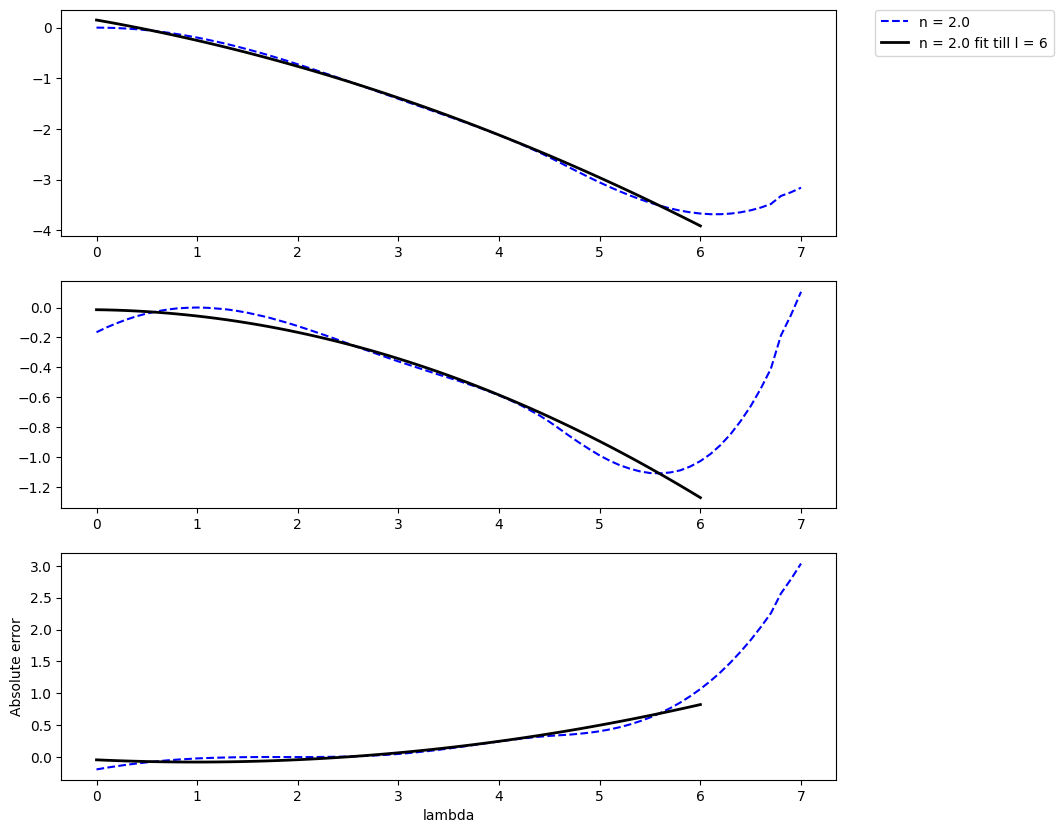

In [ ]:
# plotting error between frac_energies and predictions_n 
# Suggests that we should decrease the power to about 2.0 corresp to k = 15
fig, (ax1, ax2,ax3) = plt.subplots(3,1, figsize = (10,10))
x_axis = np.linspace(0,max_lam,steps + 1)
for k in range(len(predictions_n)):
    if k == 15:
        ax1.plot(x_axis,frac_energies - predictions_n[k][0],'b--',label=f'n = {round(0.5 + k*0.1,2)}')
        ax2.plot(x_axis,frac_energies - predictions_n[k][1],'b--',label=f'n = {round(0.5 + k*0.1,2)}')
        ax3.plot(x_axis,frac_energies - predictions_n[k][2],'b--',label=f'n = {round(0.5 + k*0.1,2)}')
    # else:
    #     ax1.plot(x_axis,np.abs(frac_energies - predictions_n[k][0]),label=f'n = {round(0.5 + k*0.1,2)}')
    #     ax2.plot(x_axis,np.abs(frac_energies - predictions_n[k][1]),label=f'n = {round(0.5 + k*0.1,2)}')
    #     ax3.plot(x_axis,np.abs(frac_energies - predictions_n[k][2]),label=f'n = {round(0.5 + k*0.1,2)}')
        
# plotting the n = 7/3 quad errors

# ax1.plot(x_axis,np.abs(frac_energies - prediction_7_3[0]),label=f'n = {round(7/3,2)}', color = 'black', linewidth = 2)
# ax2.plot(x_axis,np.abs(frac_energies - prediction_7_3[1]),label=f'n = {round(7/3,2)}', color = 'black', linewidth = 2)
# ax3.plot(x_axis,np.abs(frac_energies - prediction_7_3[2]),label=f'n = {round(7/3,2)}', color = 'black', linewidth = 2)
new_x_axis = x_axis[:61]
errs = frac_energies - predictions_n[15]
axes = [ax1, ax2, ax3]
n_2_fit_err = []
for i in range(3):
    popt_, pcov_ = curve_fit(quad_fit, new_x_axis, errs[i][:61],absolute_sigma=True)
    fitted_err_ = np.array(quad_fit(new_x_axis, *popt_))
    n_2_fit_err.append(fitted_err_)
    axes[i].plot(new_x_axis, fitted_err_, label = f'n = {round(0.5 + 15*0.1,2)} fit till l = 6', color = 'black', linewidth = 2)
n_2_quad_adj = n_2_fit_err + predictions_n[15][:,:61]
plt.xlabel("lambda")
plt.ylabel("Absolute error")
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

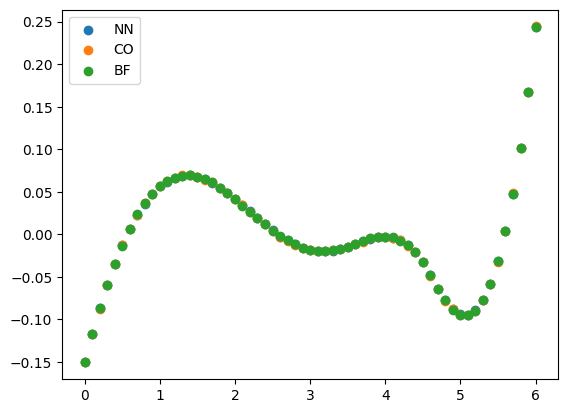

In [ ]:
'''plotting actual err between n_2_quad_adj and frac_energies'''
plt.scatter(x_axis[:61], frac_energies[:61] - n_2_quad_adj[0], label = 'NN')
plt.scatter(x_axis[:61], frac_energies[:61] - n_2_quad_adj[1], label = 'CO')
plt.scatter(x_axis[:61], frac_energies[:61] - n_2_quad_adj[2], label = 'BF')
plt.legend()

In [ ]:
x = [1,2,3,4,5]
y = [1,2.3,2.7,4.5,5]
np.corrcoef(x,y)

array([[1.        , 0.98240551],
       [0.98240551, 1.        ]])

Text(0.5, 0.98, 'Errors for different n where $Z(\\lambda) = (Z_i^n + \\lambda (Z_f^n-Z_i^n))^{\\frac{1}{n}}$')

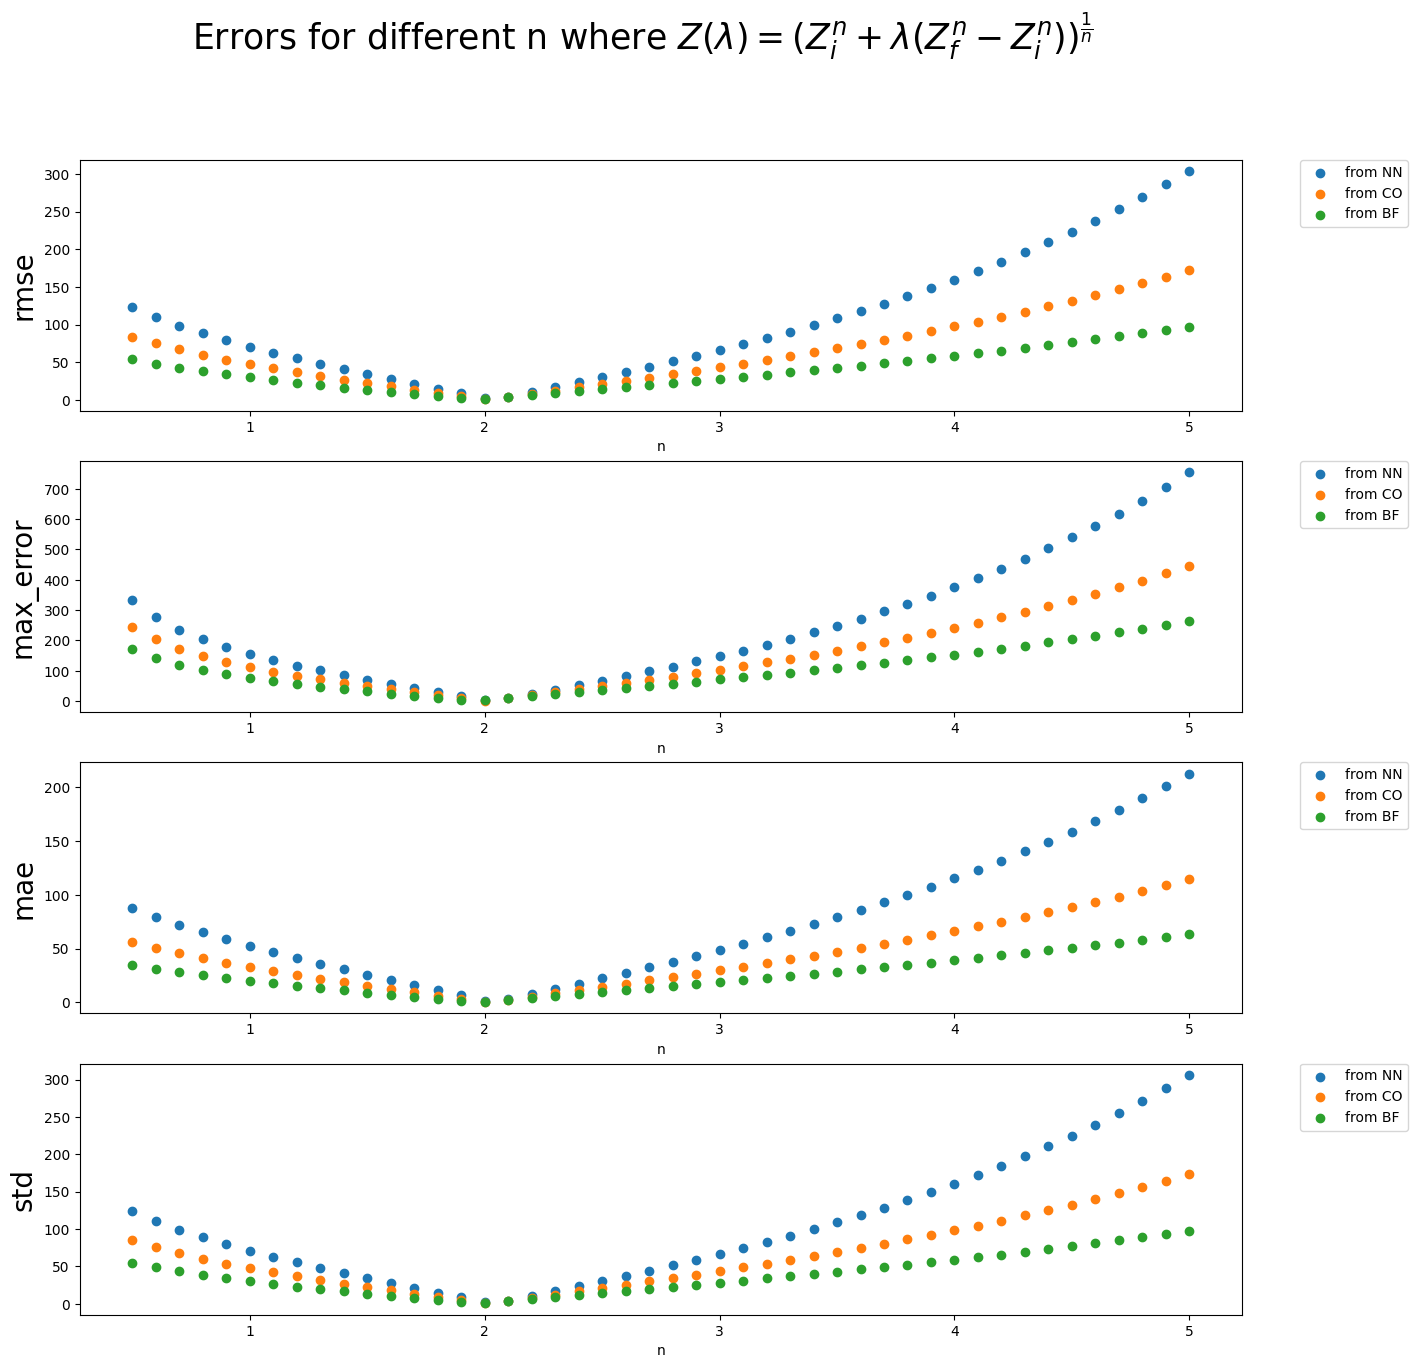

In [ ]:
'''PLotting all the errors w.r.t. to n'''
error_funcs = [rmse, max_error, mae, std]
all_errors = []
for f in error_funcs:
    error = []
    for k in range(len(predictions_n)):
        # k accesses the predictions related to n = 0.5 + k*0.1
        # 0, 1, 2 accesses the NN, CO, BF predictions respectively
        # store errors in a list
        error.append(f(frac_energies,predictions_n[k][0]))
        error.append(f(frac_energies,predictions_n[k][1]))
        error.append(f(frac_energies,predictions_n[k][2]))
    all_errors.append(np.array(error))

# plot errors
fig, (ax1, ax2,ax3, ax4) = plt.subplots(4,1, figsize = (15,15))
n_axis = np.linspace(0.5,5,46)
axes = [ax1, ax2, ax3, ax4]
for i in range(len(axes)):
    axes[i].scatter(n_axis,all_errors[i][0::3],label='from NN')
    axes[i].scatter(n_axis,all_errors[i][1::3],label='from CO')
    axes[i].scatter(n_axis,all_errors[i][2::3],label='from BF')
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    axes[i].set_xlabel("n")
    axes[i].set_ylabel(error_funcs[i].__name__)
    axes[i].yaxis.label.set_size(20)
# set title for whole figure
fig.suptitle(r'Errors for different n where $Z(\lambda) = (Z_i^n + \lambda (Z_f^n-Z_i^n))^{\frac{1}{n}}$', fontsize=25)

In [ ]:
'''Fititng quadratic errors'''

quad_err = frac_energies - prediction_7_3
x_axis = np.linspace(0,max_lam,steps + 1)

popt_NN, pcov_NN = curve_fit(quad_fit, x_axis, quad_err[0],absolute_sigma=True)
fitted_err_NN = np.array(quad_fit(x_axis, *popt_NN))

popt_CO, pcov_CO = curve_fit(quad_fit, x_axis, quad_err[1],absolute_sigma=True)
fitted_err_CO = np.array(quad_fit(x_axis, *popt_CO))

popt_BF, pcov_BF = curve_fit(quad_fit, x_axis, quad_err[2],absolute_sigma=True)
fitted_err_BF = np.array(quad_fit(x_axis, *popt_BF))

quad_adjusted_prediction = prediction_7_3 +np.array([fitted_err_NN, fitted_err_CO, fitted_err_BF])

In [ ]:
'''Fititng quartic error'''
def quart_fit(x, a, b, c,d,e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

quart_err = frac_energies - quad_adjusted_prediction
popt_NN, pcov_NN = curve_fit(quart_fit, x_axis, quart_err[0],absolute_sigma=True)
q_fitted_err_NN = np.array(quart_fit(x_axis, *popt_NN))

popt_CO, pcov_CO = curve_fit(quart_fit, x_axis,  quart_err[1],absolute_sigma=True)
q_fitted_err_CO = np.array(quart_fit(x_axis, *popt_CO))

popt_BF, pcov_BF = curve_fit(quart_fit, x_axis,  quart_err[2],absolute_sigma=True)
q_fitted_err_BF = np.array(quart_fit(x_axis, *popt_BF))

quart_adjusted_prediction = quad_adjusted_prediction +np.array([q_fitted_err_NN, q_fitted_err_CO, q_fitted_err_BF])

### issue in fitting here

/var/folders/qy/_rg_prqx1kn6x4b6bg336mk40000gn/T/ipykernel_58568/3302026886.py:3: RuntimeWarning: divide by zero encountered in power
  return x**b + x*A*np.sin(f*x + p)


0.9772372209558107

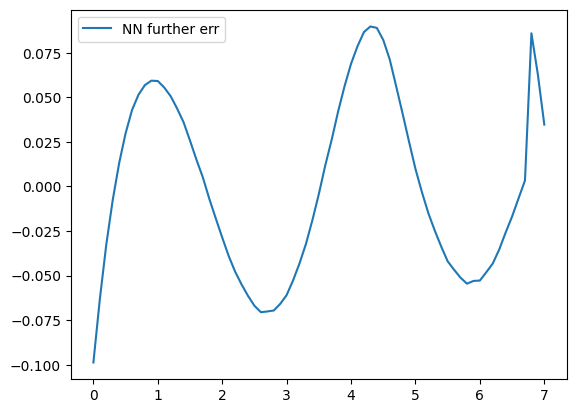

In [ ]:
'''fitting further error'''
def power_sine(x, b,A, f, p):
    return x**b + x*A*np.sin(f*x + p)
x_axis = np.linspace(0,max_lam,steps + 1)
further_err = frac_energies - quart_adjusted_prediction
poo = [ 0.01, .03054518,  1.4933,  1.14250962]
popt_NN, pcov_NN = curve_fit(power_sine, x_axis, further_err[0],p0=poo,absolute_sigma=True)
fitted_err_NN = np.array(power_sine(x_axis, *popt_NN))

# popt_CO, pcov_CO = curve_fit(power_sine, x_axis,  further_err[1],absolute_sigma=True)
# q_fitted_err_CO = np.array(power_sine(x_axis, *popt_CO))

# popt_BF, pcov_BF = curve_fit(power_sine, x_axis,  further_err[2],absolute_sigma=True)
# q_fitted_err_BF = np.array(power_sine(x_axis, *popt_BF))
app = np.array(power_sine(x_axis, *poo))
plt.plot(x_axis, further_err[0],label='NN further err')
# plt.plot(x_axis, app,label='app')
# plt.plot(x_axis, further_err[1])
# plt.plot(x_axis, further_err[2])
# plt.plot(x_axis, fitted_err_NN)
# plt.plot(x_axis, q_fitted_err_CO)
# plt.plot(x_axis, q_fitted_err_BF)
plt.legend()
power_sine(0.1,*poo)
0.1**0.01

/var/folders/qy/_rg_prqx1kn6x4b6bg336mk40000gn/T/ipykernel_58568/1358204027.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['NN','CO','BF','BeNe','LiNa','HeMg','HAl','Si'])


[Text(0.0, 1, 'NN'),
 Text(1.0, 1, 'CO'),
 Text(2.0, 1, 'BF'),
 Text(3.0, 1, 'BeNe'),
 Text(4.0, 1, 'LiNa'),
 Text(5.0, 1, 'HeMg'),
 Text(6.0, 1, 'HAl'),
 Text(7.0, 1, 'Si')]

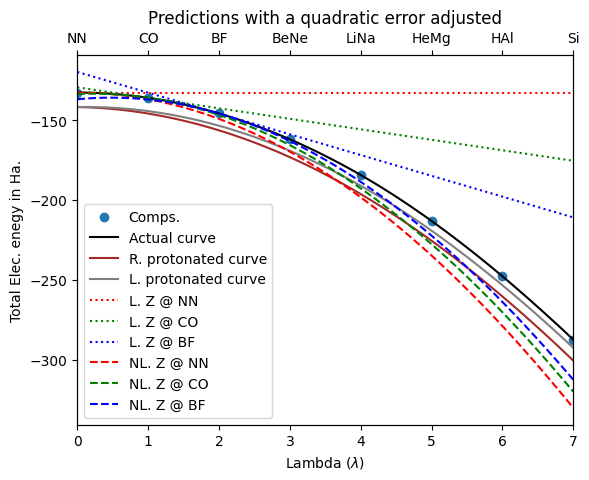

In [ ]:
'''Plotting graph for symmetrical alchemical changes'''

# plotting the linearzied Z predictions
l_vals = np.array([np.array(x) for x in [pre_NN_l,pre_CO_l,pre_BF_l]])
l_keys = ['L. Z @ NN', 'L. Z @ CO','L. Z @ BF']
nl_keys = ['NL. Z @ NN','NL. Z @ CO','NL. Z @ BF']

l_lines = dict(zip(l_keys, l_vals))
nl_lines = dict(zip(nl_keys,prediction_7_3))
all_lines = {**l_lines, **nl_lines}

format = ['r:','g:', 'b:','r--','g--', 'b--']

# figure(figsize=(8, 6), dpi=80)
fig, ax = plt.subplots()
ax.scatter([0,1,2,3,4,5,6,7],[e_NN, e_CO, e_BF, e_BeNe, e_LiNA, e_HeMg, e_HAl, e_Si],label='Comps.')
ax.plot(x_axis,np.array(frac_energies),'black',label='Actual curve')
ax.plot(x_axis,np.array(R_P),'brown',label='R. protonated curve')
ax.plot(x_axis,np.array(L_P),'grey',label='L. protonated curve')
# ax.plot(x_axis,)
i = 0
for line in all_lines:
    # plt.scatter(np.linspace(0,2,len(lines[line])),lines[line],label=line)
    plt.plot(x_axis,all_lines[line],format[i],label=line)
    i +=1
ax.legend()
ax.set_ylabel('Total Elec. enegy in Ha.')
ax.set_xlabel(r'Lambda ($\lambda$)')
ax.set_xlim(0,7)
ax.set_title('Predictions with a quadratic error adjusted')

# add another x axis in plot
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticklabels(['NN','CO','BF','BeNe','LiNa','HeMg','HAl','Si'])

Text(0.5, 1.0, 'Error after adjusting quadratic')

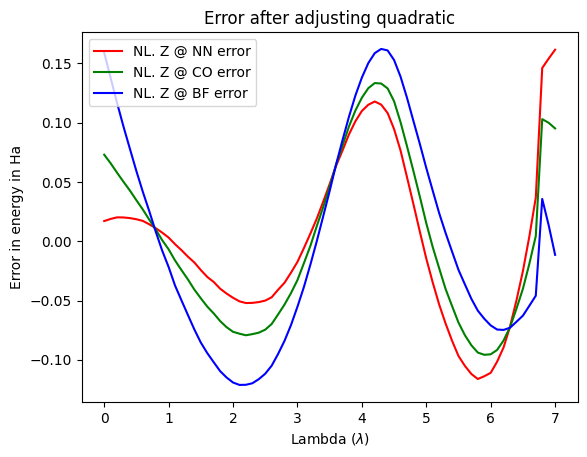

In [ ]:
'''Plotting after quad error is adjusted for symmetrical alchemical changes.'''
plt.plot(x_axis, frac_energies -quad_adjusted_prediction[0],'r',label='NL. Z @ NN error')
plt.plot(x_axis, frac_energies - quad_adjusted_prediction[1],'g',label='NL. Z @ CO error')
plt.plot(x_axis, frac_energies - quad_adjusted_prediction[2],'b',label='NL. Z @ BF error')
plt.legend()
plt.xlabel(r'Lambda ($\lambda$)')
plt.ylabel('Error in energy in Ha')
plt.title('Error after adjusting quadratic')

Text(0.5, 1.0, 'After adjusting quaritc errors')

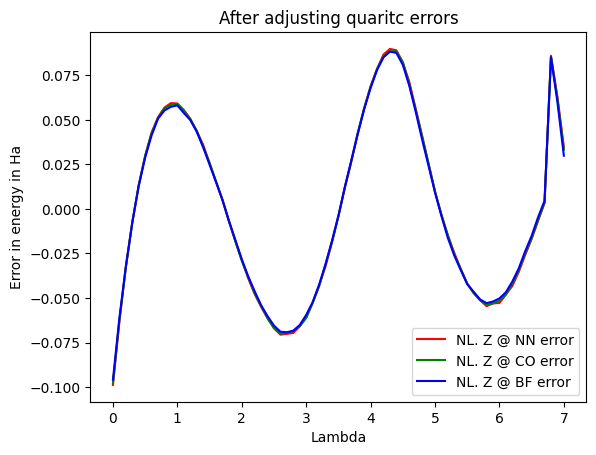

In [ ]:
'''Plotting after quartic error is adjusted for symmetrical alchemical changes.'''
plt.plot(x_axis, frac_energies - quart_adjusted_prediction[0],'r',label='NL. Z @ NN error')
plt.plot(x_axis, frac_energies - quart_adjusted_prediction[1],'g',label='NL. Z @ CO error')
plt.plot(x_axis, frac_energies - quart_adjusted_prediction[2],'b',label='NL. Z @ BF error')
plt.legend()
plt.xlabel('Lambda')
plt.ylabel('Error in energy in Ha')
plt.title('After adjusting quaritc errors')

## lambda exponentiated fourier approximations

In [ ]:
# fit function for variable number of terms in fourier series
def ff(lam, *args):
    A = np.array(args[0::5])
    f = np.array(args[1::5])
    p = np.array(args[2::5])
    exp = np.array(args[3::5])
    C = np.array(args[4::5])
    return sum(A[i]*np.exp(lam*exp[i]) * np.sin(lam*f[i] + p[i]) + C[i] for i in range(len(C)))
comps = ['NN', 'CO','BF']
# fitting the eror after adjusting quadratic error.
err_to_fit = frac_energies[:61] - n_2_quad_adj
def get_fourier_pred(N):
    '''Gets the lambda dependent fourier prediction upto Nth order for the error after adjusting the quadratic error.'''
    fits = []
    x_axis = np.linspace(0,max_lam,steps + 1)[:61]
    base = (3.977507e-02,  1.83432473e+00, -1.20482758e+01,  1.16835373e-01,
            5.40220558e-03)
    for i in range(1,N):
        base += (3.977507e-02,  1.83432473e+00, -1.20482758e+01,  1.16835373e-01,
            5.40220558e-03)

    for j in range(3):
        popt, pcov = curve_fit(ff, x_axis, err_to_fit[j],p0=base,absolute_sigma=True,maxfev=100000)
        # print(popt)
        fits.append(ff(x_axis,*popt))
        # print(f'b is {popt[0]} for {comps[j]}')
    
    return np.array(fits) + n_2_quad_adj
# + quad_adjusted_prediction

# plt.plot(x_axis, quart_err[0],label='NN quartic error')

# plt.plot(x_axis, quart_err[1],label='CO quartic error')
# plt.plot(x_axis, quart_err[2],label='BF quartic error')


In [ ]:
# f1 = np.abs(2/steps*fft.fftshift(fft.fft(quart_err[0])))
# frequencies = fft.fftfreq(steps+1,1)
# frequencies = fft.fftshift(frequencies)

# plt.plot(frequencies, f1)
# find_peaks(f1,height=0.05)
# # plt.plot(frequencies,y_dat,label='fft')
# frequencies[37]

### Calculating and plotting interaction energies / measures of models

$$\Delta_1 = E^{int}_{ele} = E^{Tot}_{ele} - \sum_{I} E^{free}_{I, ele}$$

this can be done for all $n$, where $E^{free}_{I, ele} \approx -\dfrac{1}{2}Z_I^n$

quad adj.
False
quart adj.
False
False
False
False
n = 2.0 for free E
False
quad adj.
False
quart adj.
False
False
False
False
n = 2.0 for free E
False
quad adj.
False
quart adj.
False
False
False
False
n = 2.0 for free E
False


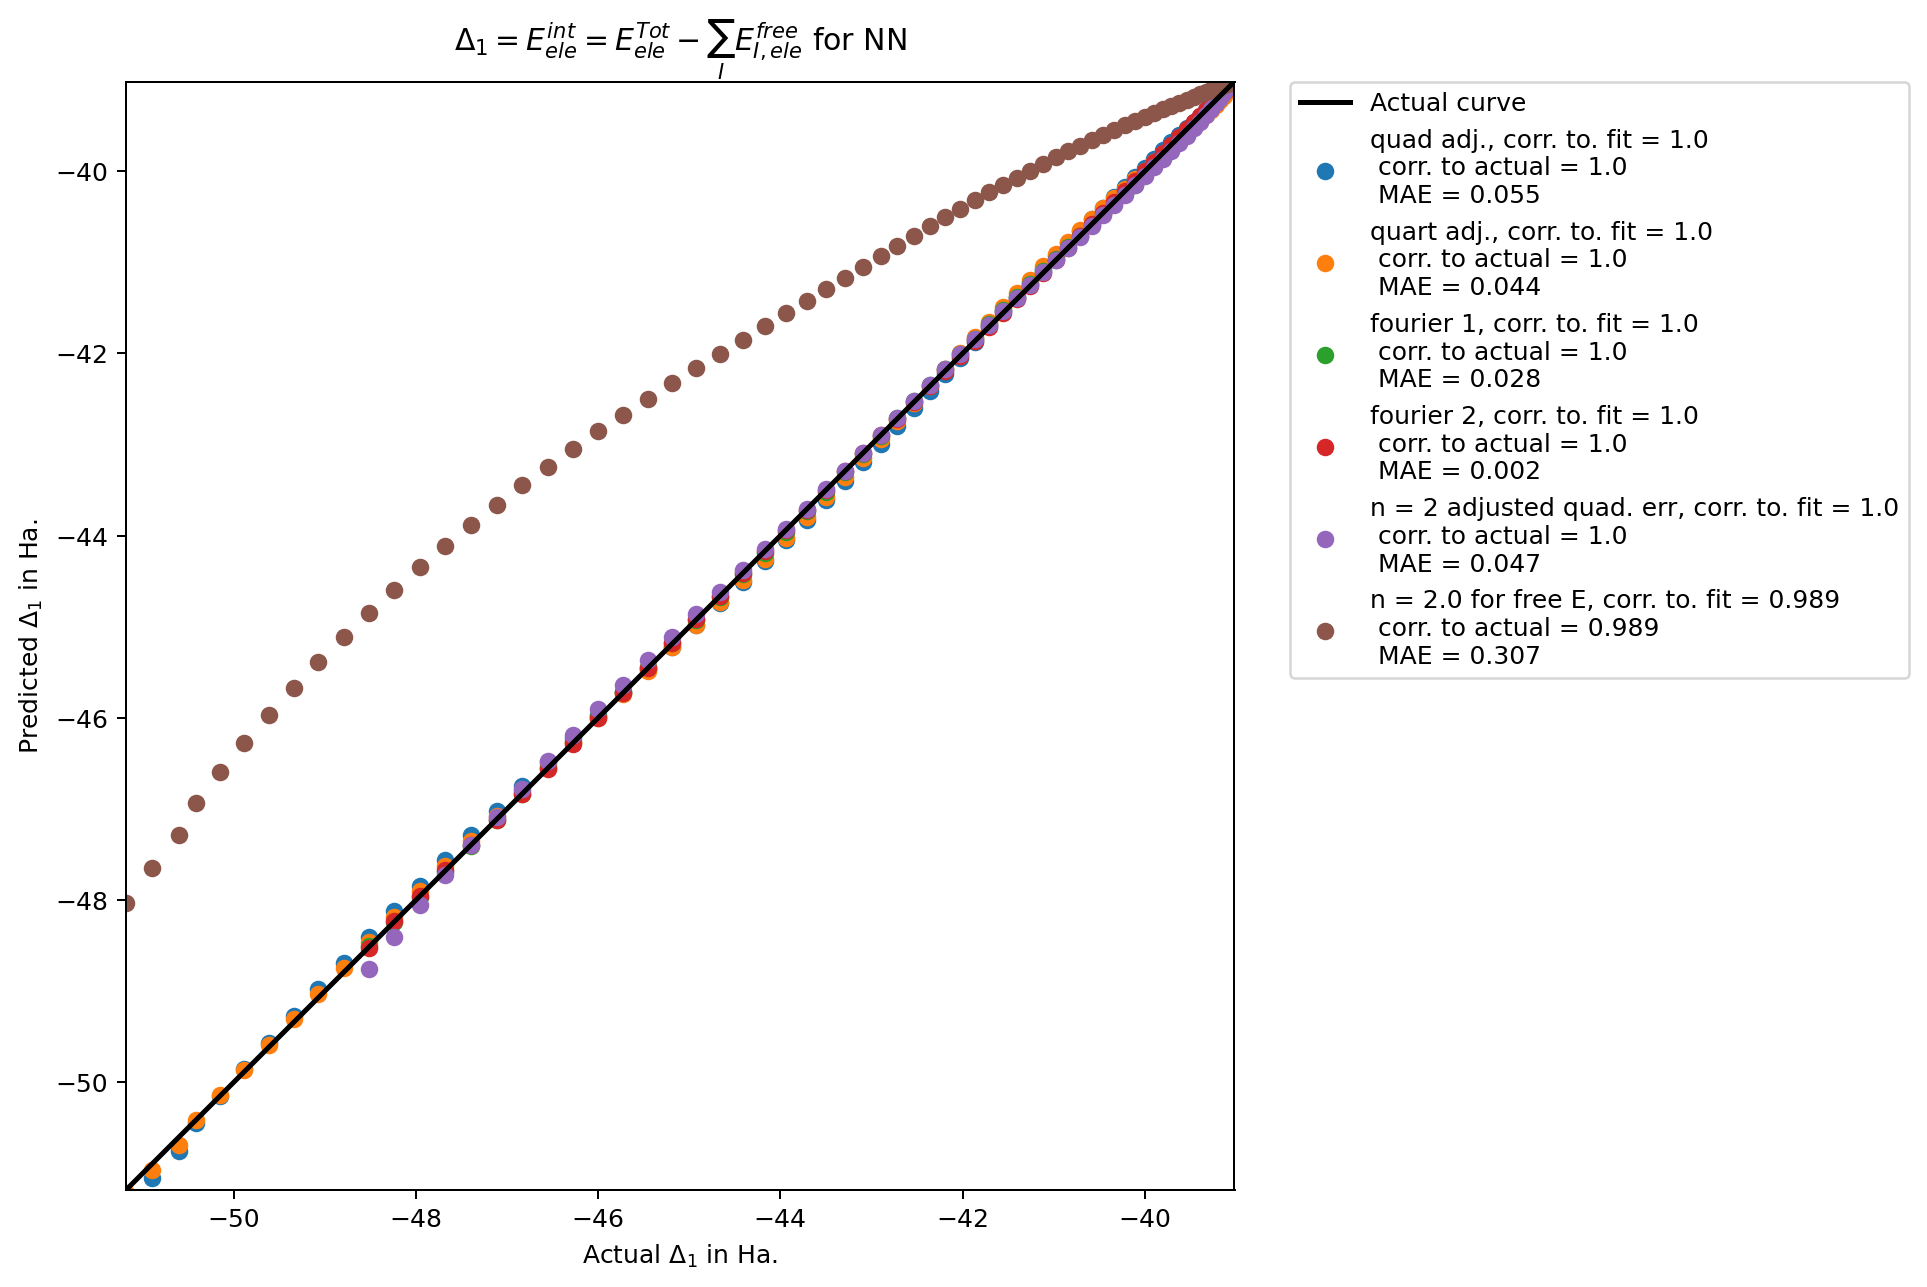

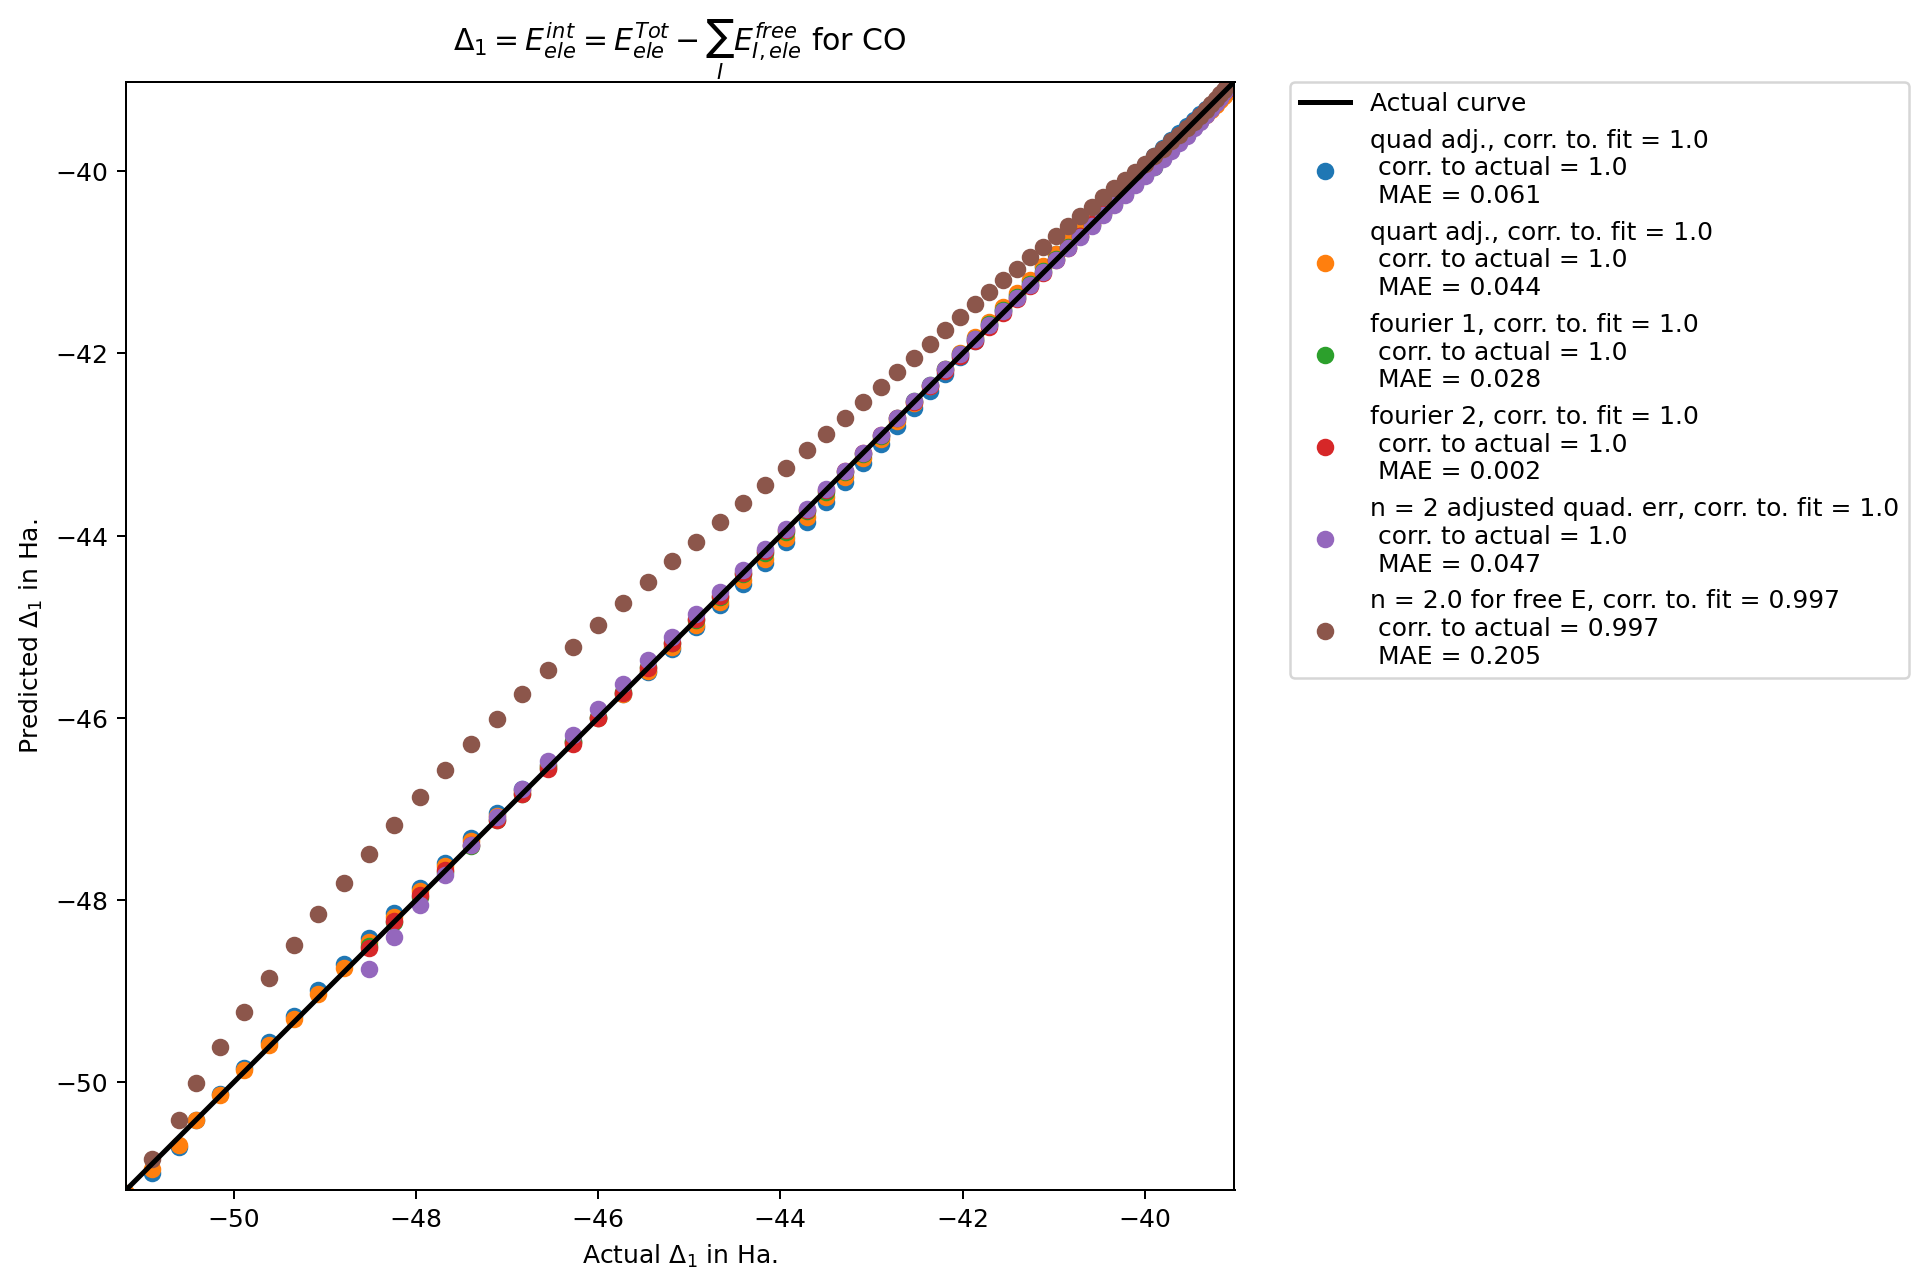

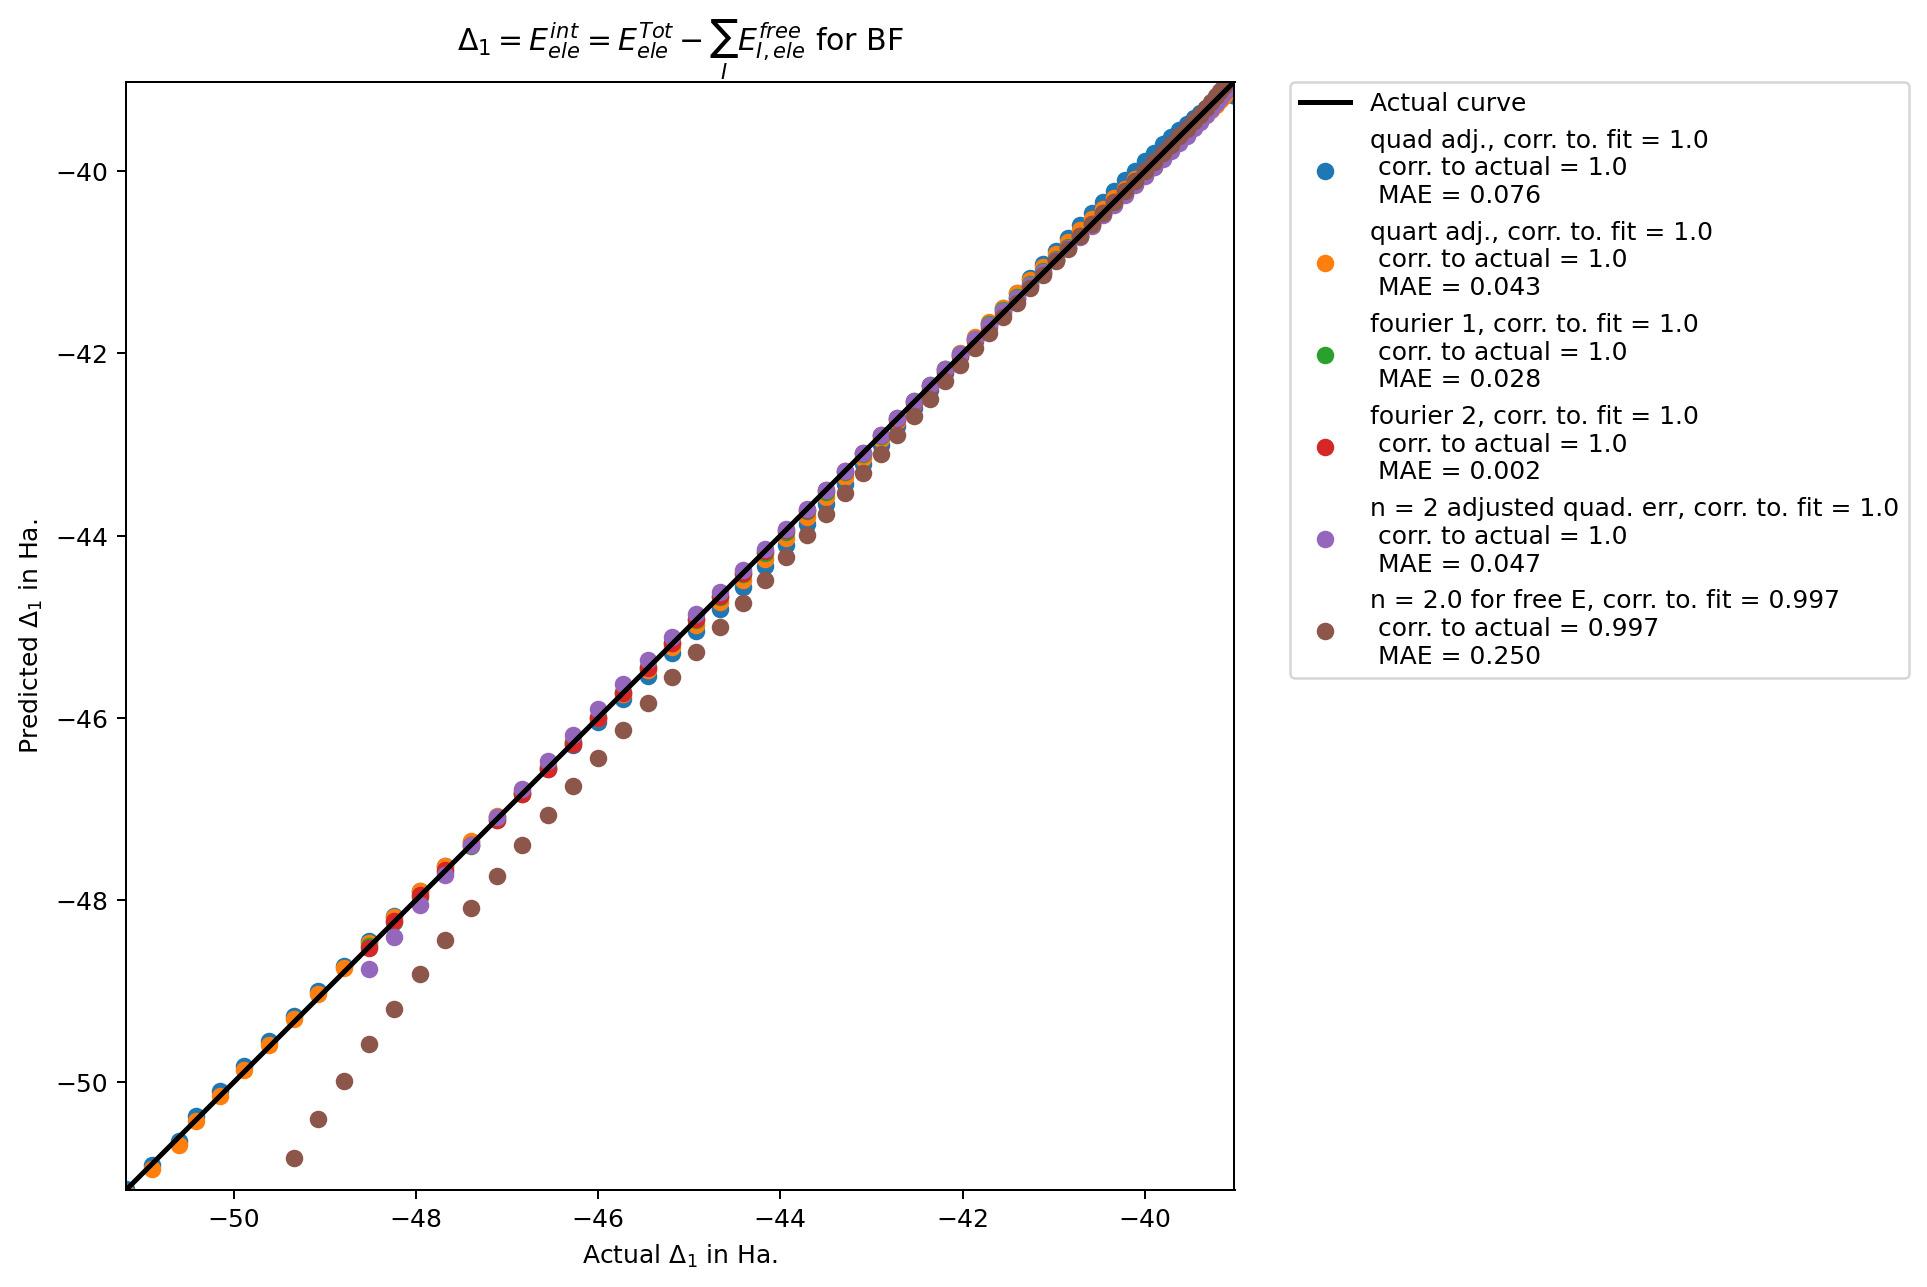

In [ ]:
comps = ['NN', 'CO', 'BF']
models = [quad_adjusted_prediction, quart_adjusted_prediction, \
    get_fourier_pred(1), get_fourier_pred(2), n_2_quad_adj,predictions_n[15]]
labels = ['quad adj.', 'quart adj.', 'fourier 1', 'fourier 2',\
    'n = 2 adjusted quad. err','n = 2.0 for free E']
for i in range(3):
    figure(figsize=(8, 8), dpi=180)
    x_axis = np.array(frac_energies - free_energies)
    
    plt.plot(x_axis, frac_energies - free_energies,'black',linewidth=2, label='Actual curve')
    
    for j in range(len(models)):
        if labels[j] in ['n = 2 adjusted quad. err','fourier 1', 'fourier 2']:
            xdata = x_axis[:61]
            ydata = models[j][i] - free_energies[:61]
        else:
            xdata = x_axis
            print(labels[j])
            ydata = models[j][i] - free_energies
        popt, pcov = curve_fit(lin_fit, xdata, ydata,absolute_sigma=True)
        
        fit = np.array(lin_fit(xdata, *popt))
        fit_corr_coeff = np.corrcoef(fit, ydata)[0,1]
        ac_corr_coeff = np.corrcoef(xdata, ydata)[0,1]
        print(fit_corr_coeff == ac_corr_coeff)
        plt.scatter(xdata, ydata, label=labels[j]+', corr. to. fit = '\
            +str(round(fit_corr_coeff,3))+'\n corr. to actual = '+str(round(ac_corr_coeff,3))+f'\n MAE = {mae(ydata,fit):.3f}')

    # plt.scatter(x_axis, predictions_n[15][i] - free_energies, label='n = 2.0 for E. free')
    plt.axis('square')
    plt.xlim(np.min(x_axis),np.max(x_axis))
    plt.ylim(np.min(x_axis),np.max(x_axis))
    # plt.ylim(-52,-38)
            # shift legend outside plots
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
   
    # set xscale equal to yscale
    
    plt.gca().set_aspect('equal', adjustable='box')
   
    plt.xlabel(r'Actual $\Delta_1$ in Ha.')
    plt.ylabel(r'Predicted $\Delta_1$ in Ha.')
    plt.title(r'$\Delta_1 = E^{int}_{ele} = E^{Tot}_{ele} - \sum_{I} E^{free}_{I, ele}$ for '+f'{comps[i]}')
    plt.savefig(f'../images/delta1/1_{comps[i]}.png')

$$\Delta_2 = E^{Tot}_{ele} / \sum_{I} E^{free}_{I, ele}$$

False
False
False
True
True
False
True
False
False
False
True
False
False
True
False
False
False
True


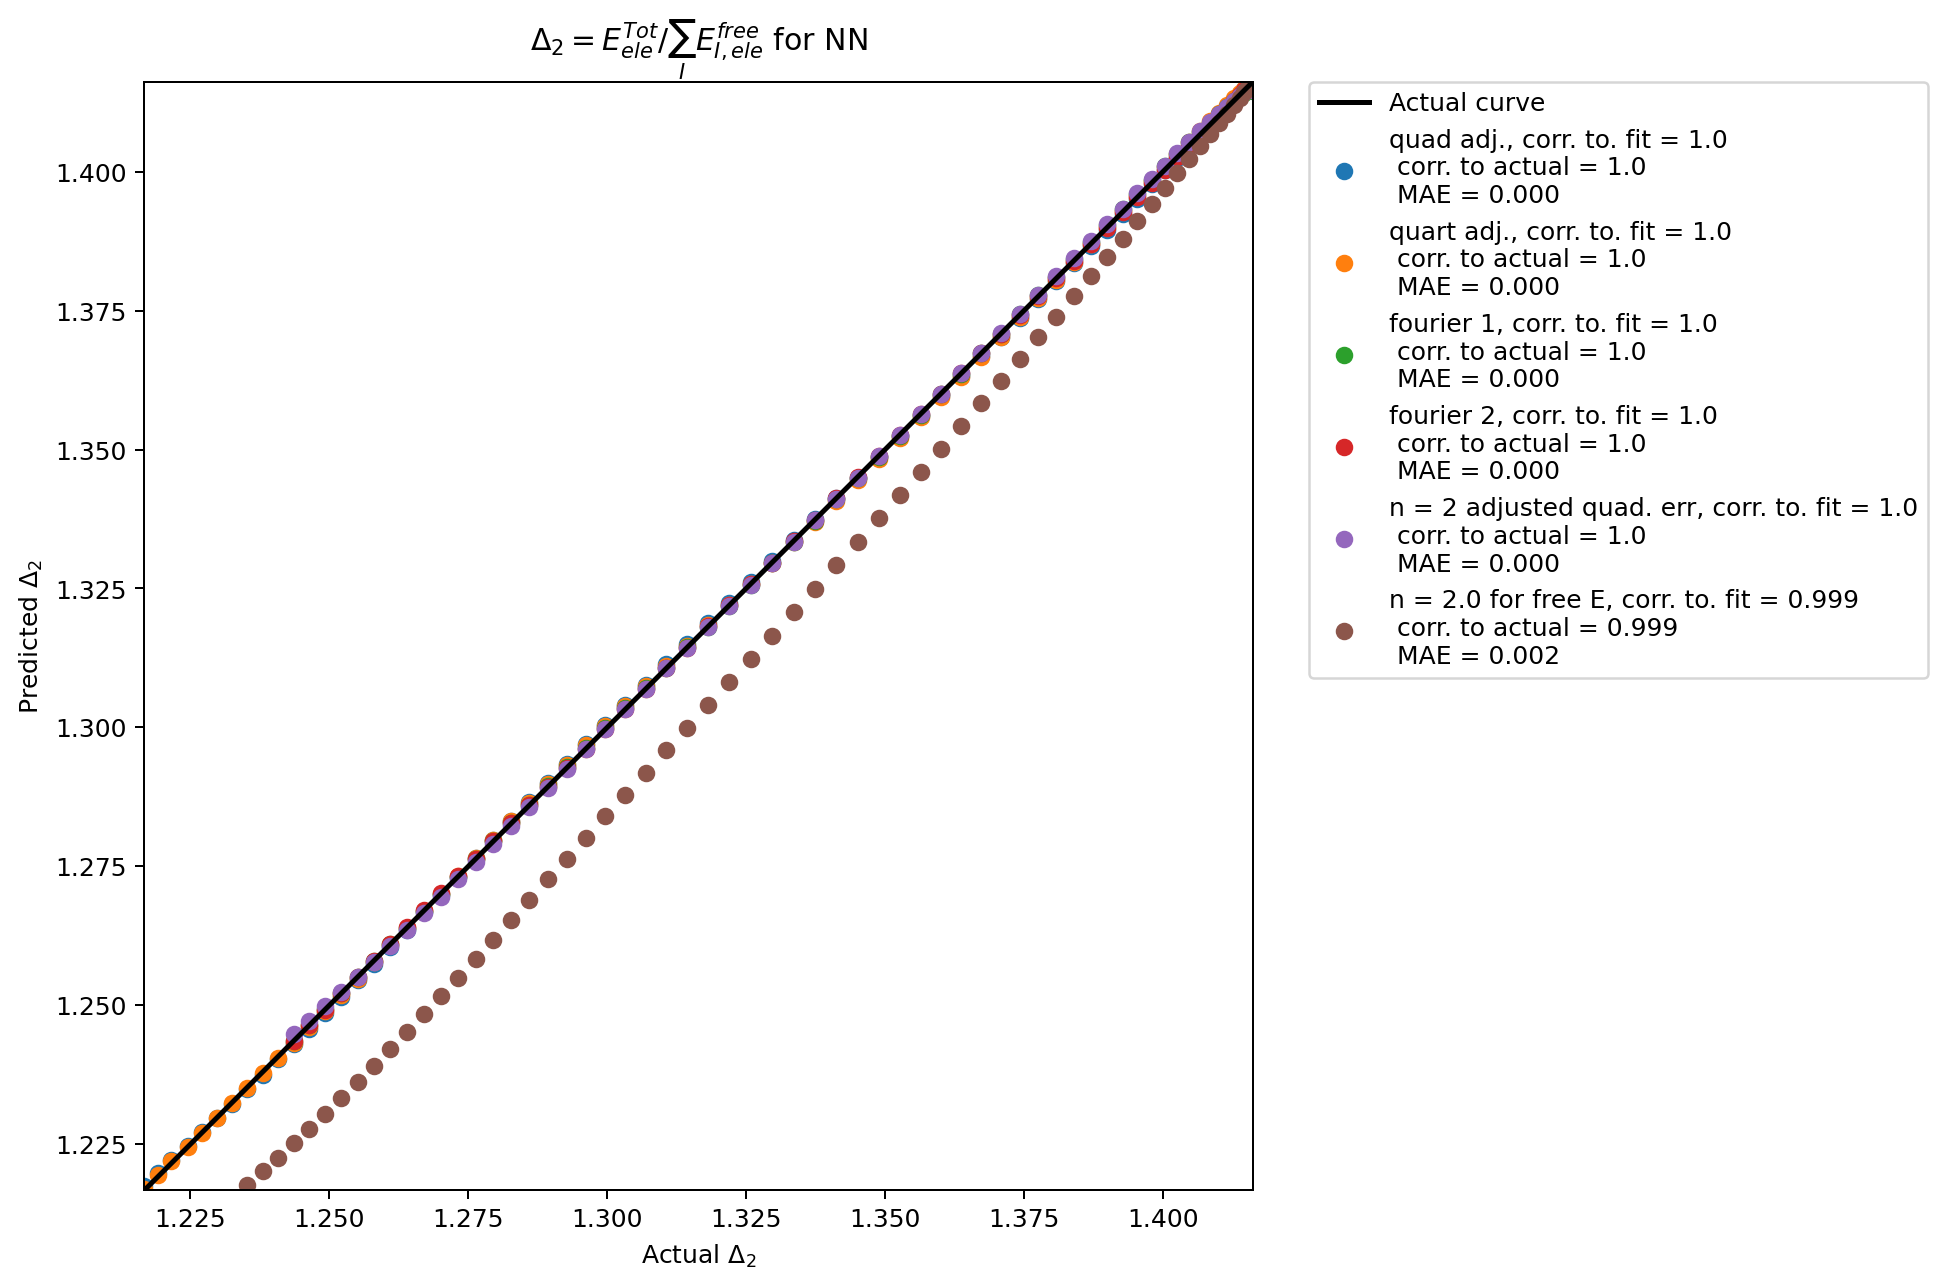

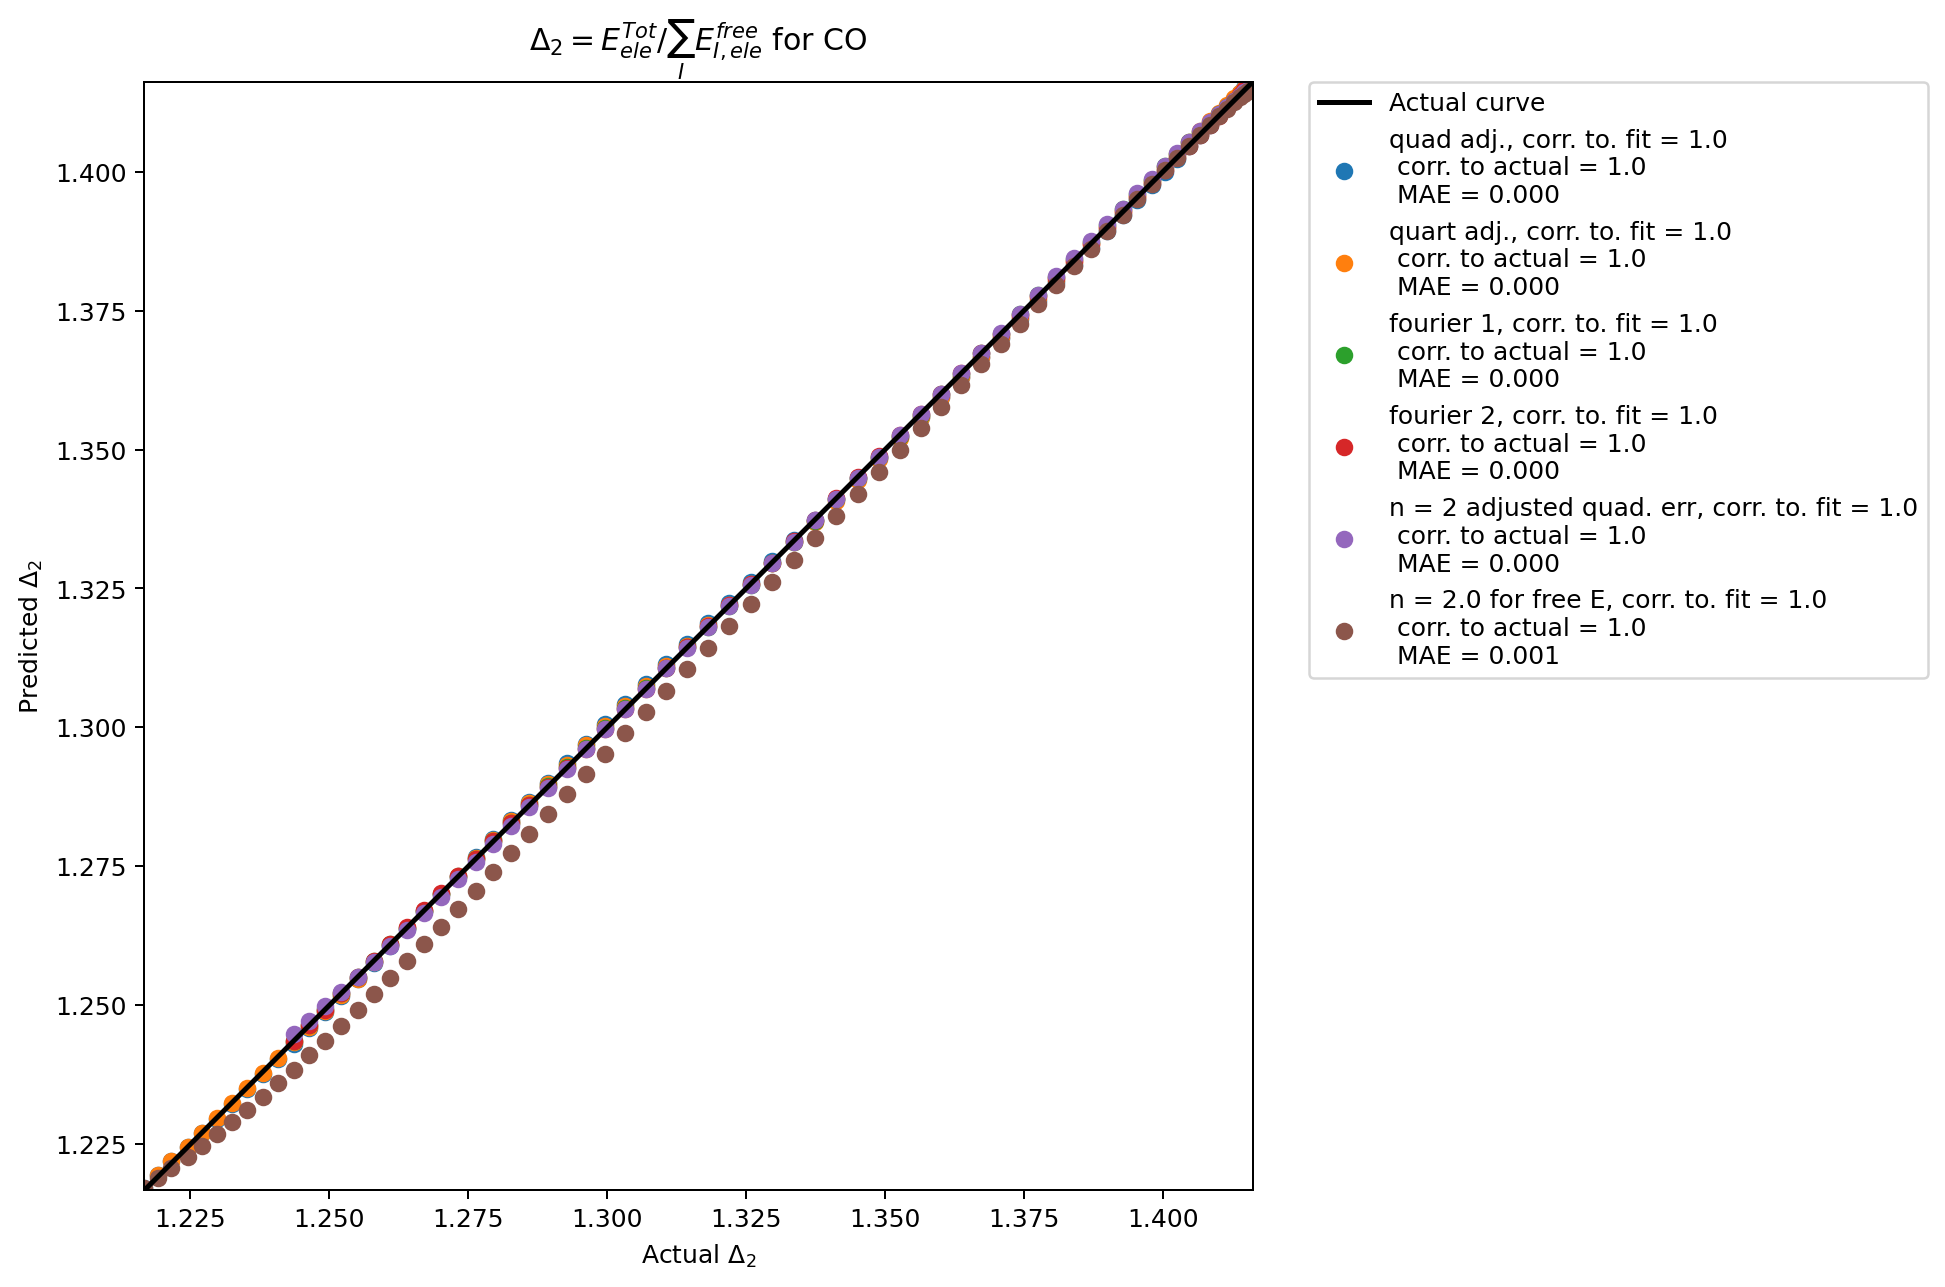

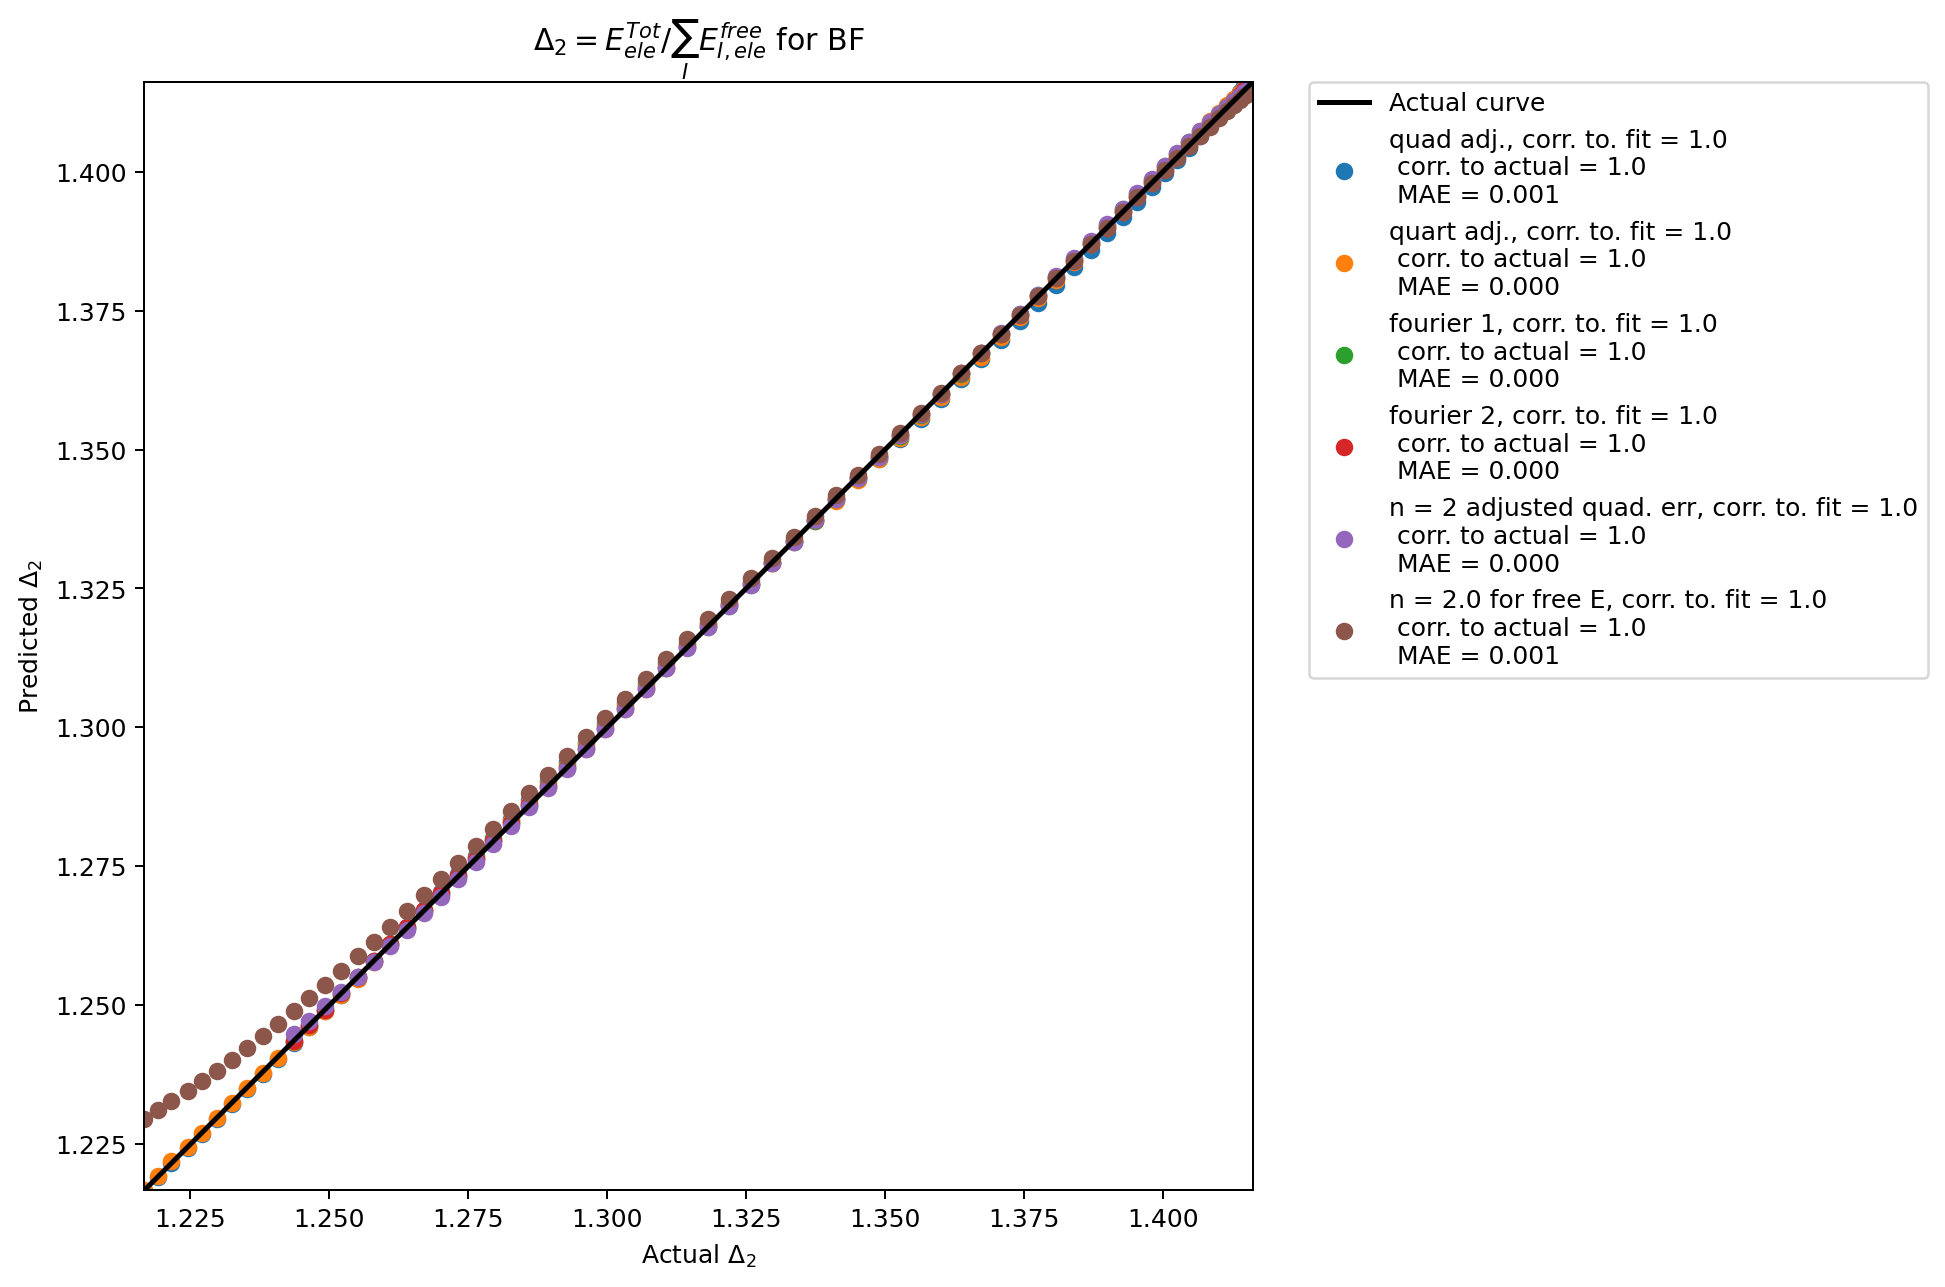

In [ ]:
comps = ['NN', 'CO', 'BF']
models = [quad_adjusted_prediction, quart_adjusted_prediction, \
    get_fourier_pred(1), get_fourier_pred(2), n_2_quad_adj,predictions_n[15]]
labels = ['quad adj.', 'quart adj.', 'fourier 1', 'fourier 2',\
    'n = 2 adjusted quad. err','n = 2.0 for free E']
for i in range(3):
    figure(figsize=(8, 8), dpi=180)
    x_axis = frac_energies / free_energies
    plt.plot(x_axis, frac_energies / free_energies,'black',linewidth=2, label='Actual curve')
    # plt.plot(x_axis, prediction_7_3[0] / free_energies, label='P. NN')
    
    for j in range(len(models)):
        if labels[j] in ['n = 2 adjusted quad. err','fourier 1', 'fourier 2']:
            xdata = x_axis[:61]
            ydata = models[j][i] / free_energies[:61]
        else:
            xdata = x_axis
            ydata = models[j][i] / free_energies
        popt, pcov = curve_fit(lin_fit, xdata, ydata,absolute_sigma=True)
        fit = np.array(lin_fit(xdata, *popt))
        fit_corr_coeff = np.corrcoef(fit, ydata)[0,1]
        ac_corr_coeff = np.corrcoef(xdata, ydata)[0,1]
        print(fit_corr_coeff == ac_corr_coeff)

        # plt.plot(xdata, fit)
        plt.scatter(xdata, ydata, label=labels[j]+', corr. to. fit = '\
            +str(round(fit_corr_coeff,3))+'\n corr. to actual = '+str(round(ac_corr_coeff,3))+f'\n MAE = {mae(ydata,fit):.3f}')
    # shift legend outside plots
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
   
    plt.axis('square')
    plt.xlim(np.min(x_axis),np.max(x_axis))
    plt.ylim(np.min(x_axis),np.max(x_axis))
    
    plt.gca().set_aspect('equal', adjustable='box')

    plt.xlabel(r'Actual $\Delta_2$')
    plt.ylabel(r'Predicted $\Delta_2$')
    plt.title(r'$\Delta_2 = E^{Tot}_{ele} / \sum_{I} E^{free}_{I, ele}$ for '+f'{comps[i]}')
    plt.savefig(f'../images/delta2/2_{comps[i]}.png')

$$\Delta_3 = E^{Prot.}_{ele} - E^{Tot.}_{ele}$$

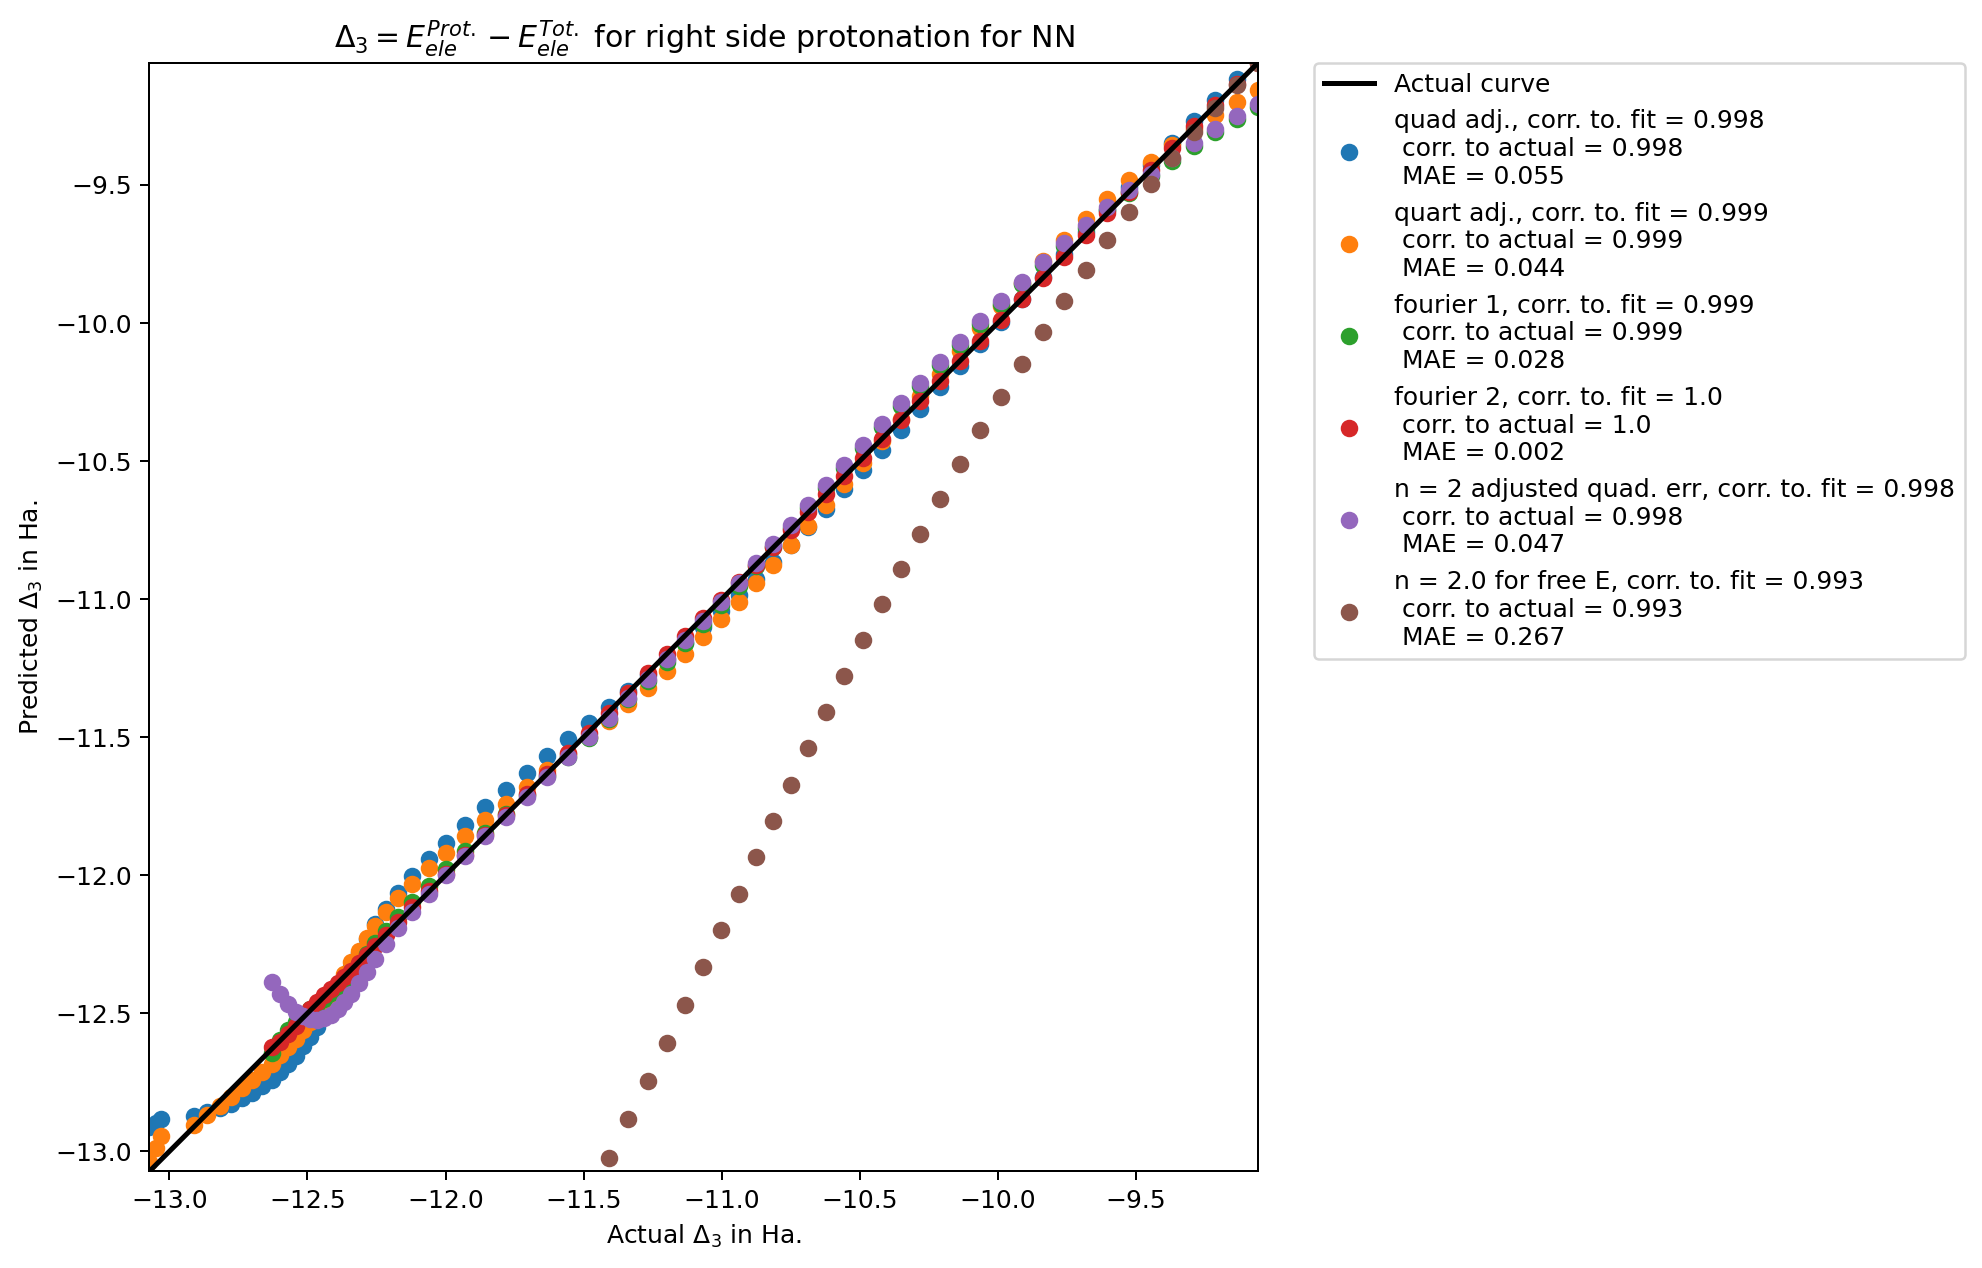

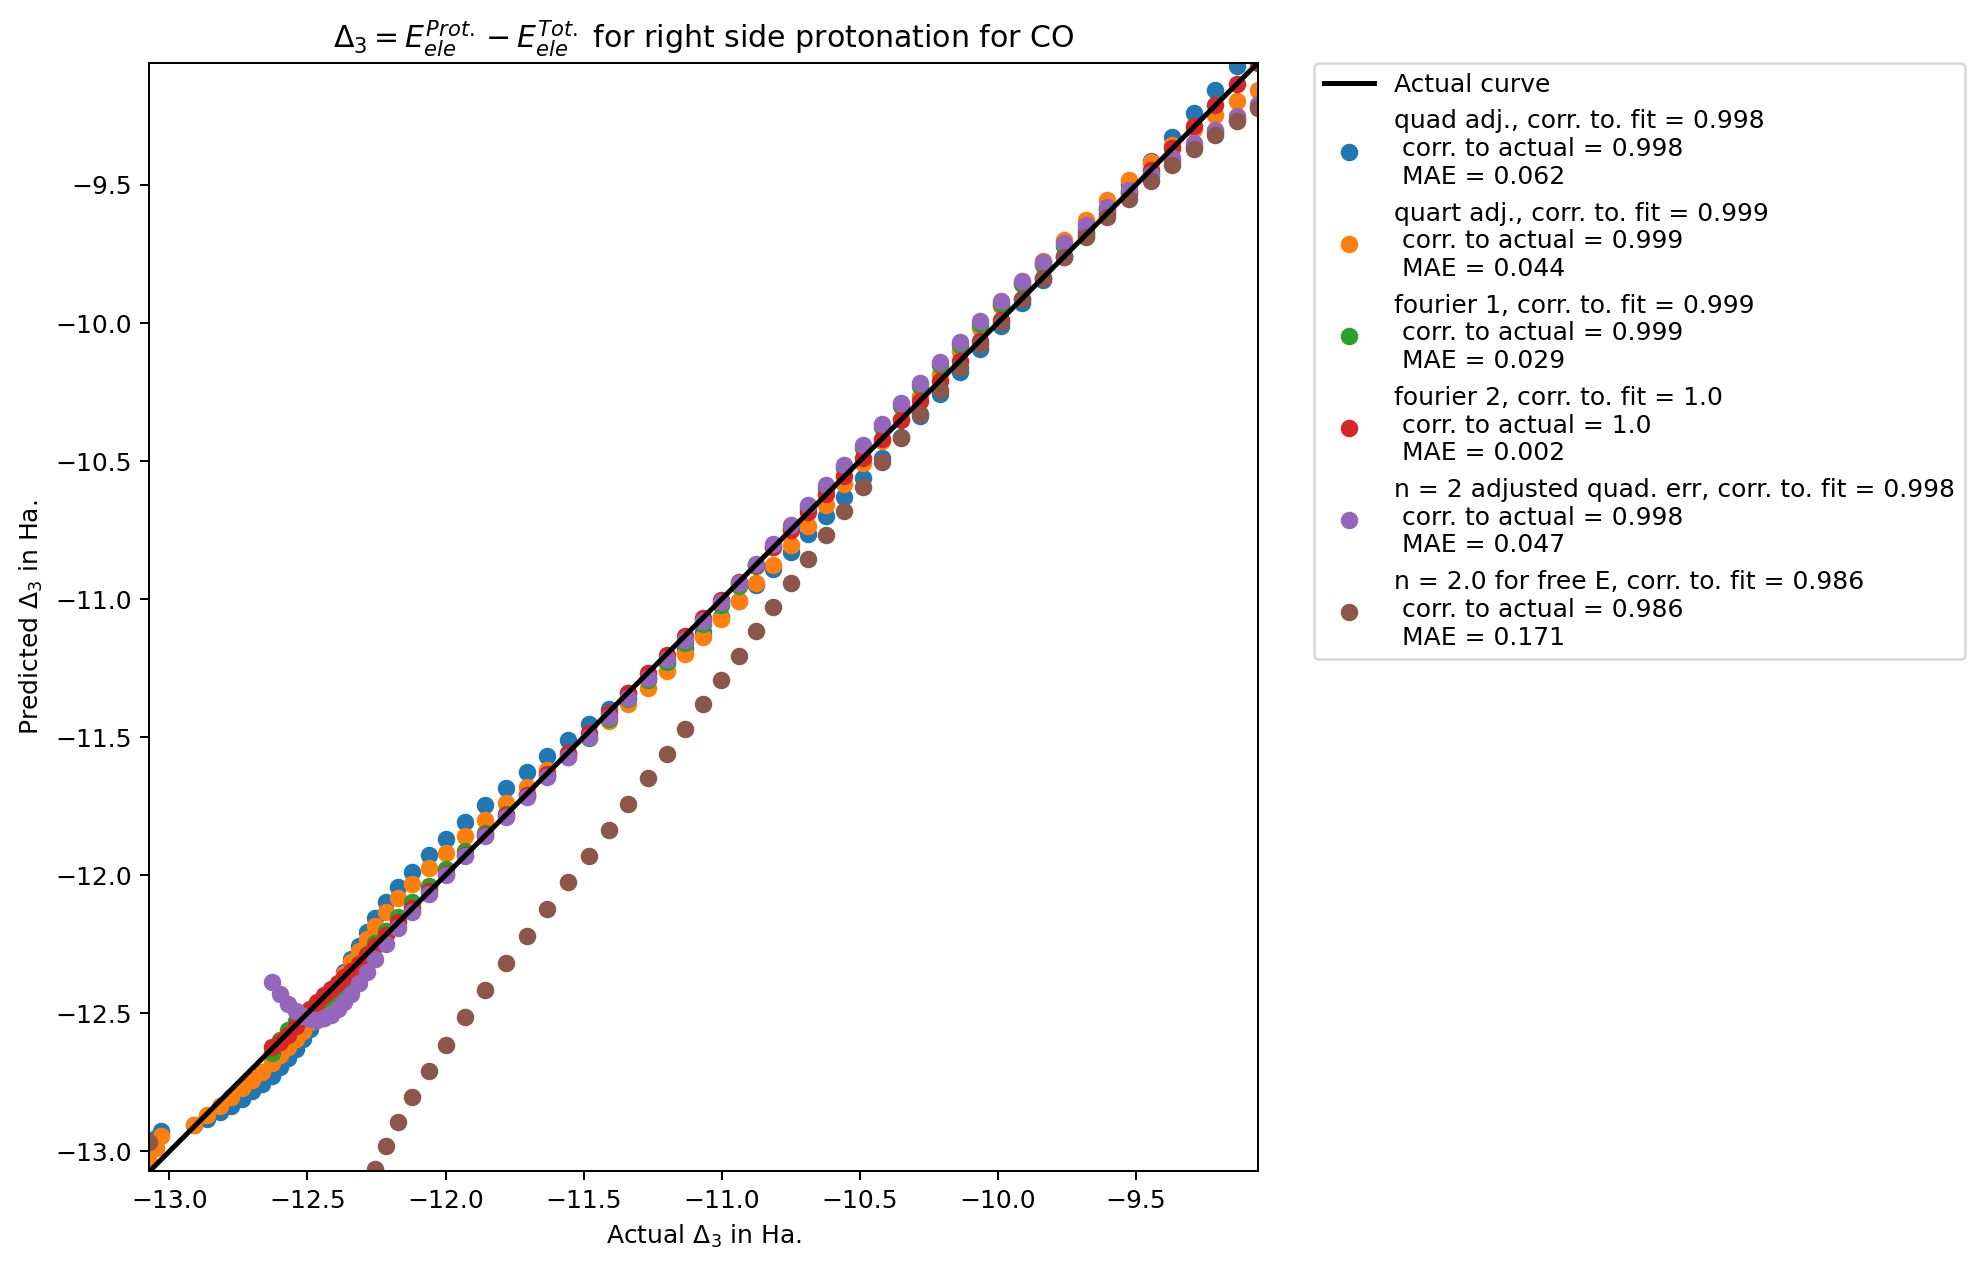

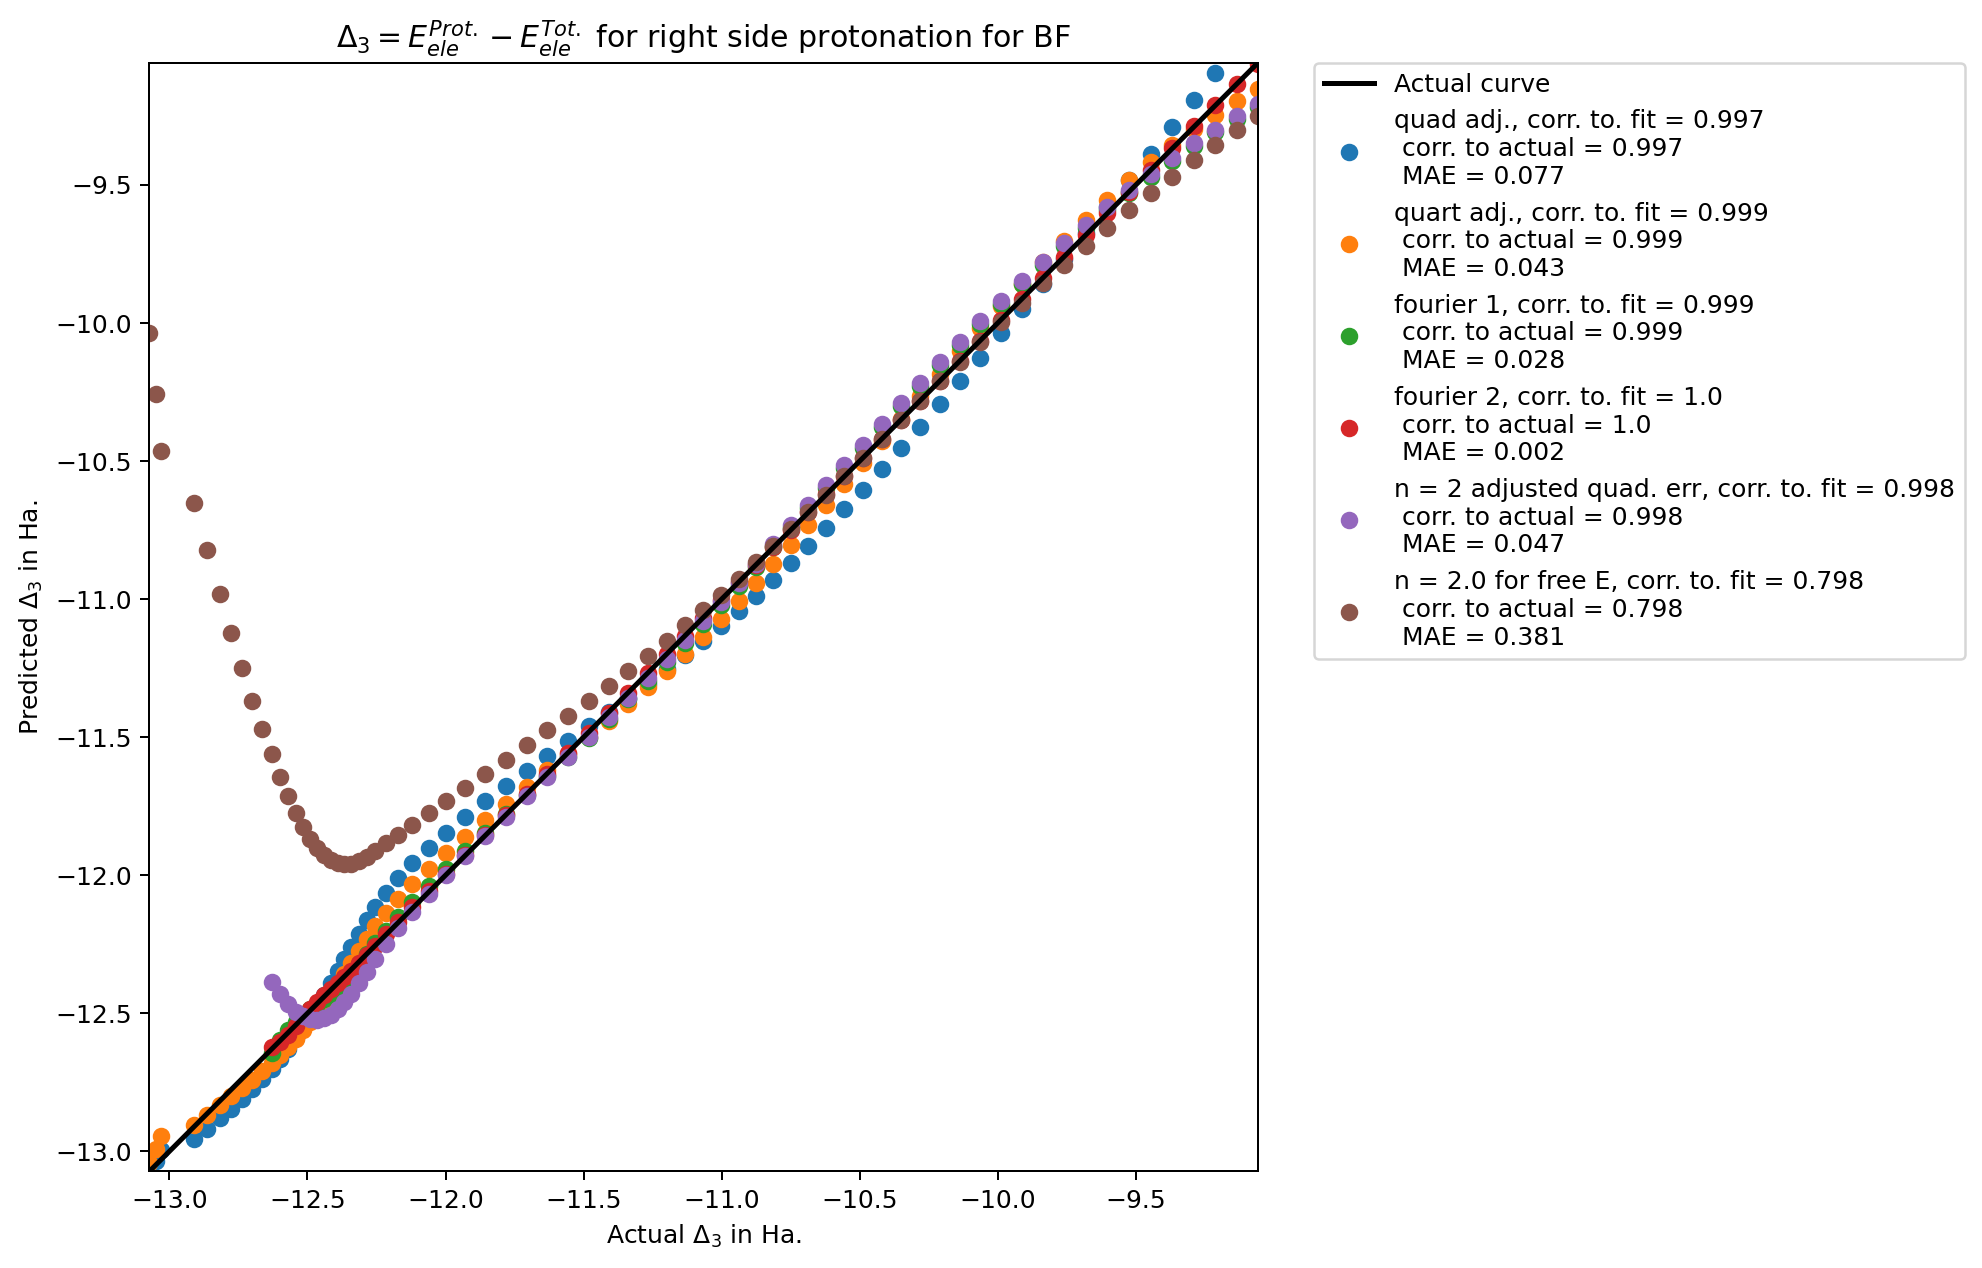

In [ ]:
'''Right side'''
comps = ['NN', 'CO', 'BF']
models = [quad_adjusted_prediction, quart_adjusted_prediction, \
    get_fourier_pred(1), get_fourier_pred(2), n_2_quad_adj,predictions_n[15]]
labels = ['quad adj.', 'quart adj.', 'fourier 1', 'fourier 2',\
    'n = 2 adjusted quad. err','n = 2.0 for free E']

for i in range(3):
    figure(figsize=(8, 8), dpi=180)
    x_axis = R_P - frac_energies
    plt.plot(x_axis, R_P - frac_energies, 'black',linewidth=2,label='Actual curve')
    # plt.scatter(x_axis, prediction_7_3[0]  , label='P. NN')
    for j in range(len(models)):
        if labels[j] in ['n = 2 adjusted quad. err','fourier 1', 'fourier 2']:
            xdata = x_axis[:61]
            ydata = R_P[:61] - models[j][i] 
        else:
            xdata = x_axis
            ydata = R_P - models[j][i] 
        popt, pcov = curve_fit(lin_fit, xdata, ydata,absolute_sigma=True)
        fit = np.array(lin_fit(xdata, *popt))
        fit_corr_coeff = np.corrcoef(fit, ydata)[0,1]
        ac_corr_coeff = np.corrcoef(xdata, ydata)[0,1]
         
        # plt.plot(xdata, fit)
        plt.scatter(xdata, ydata, label=labels[j]+', corr. to. fit = '\
            +str(round(fit_corr_coeff,3))+'\n corr. to actual = '+str(round(ac_corr_coeff,3))+f'\n MAE = {mae(ydata,fit):.3f}')
    # shift legend outside plots
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
   

    plt.axis('square')
    plt.xlim(np.min(x_axis),np.max(x_axis))
    plt.ylim(np.min(x_axis),np.max(x_axis))
    plt.gca().set_aspect('equal', adjustable='box')

    plt.xlabel(r'Actual $\Delta_3$ in Ha.')
    plt.ylabel(r'Predicted $\Delta_3$ in Ha.')
    plt.title(r'$\Delta_3 = E^{Prot.}_{ele} - E^{Tot.}_{ele}$ for right side protonation for '+f'{comps[i]}')
    plt.savefig(f'../images/delta3/3_R_{comps[i]}.png')

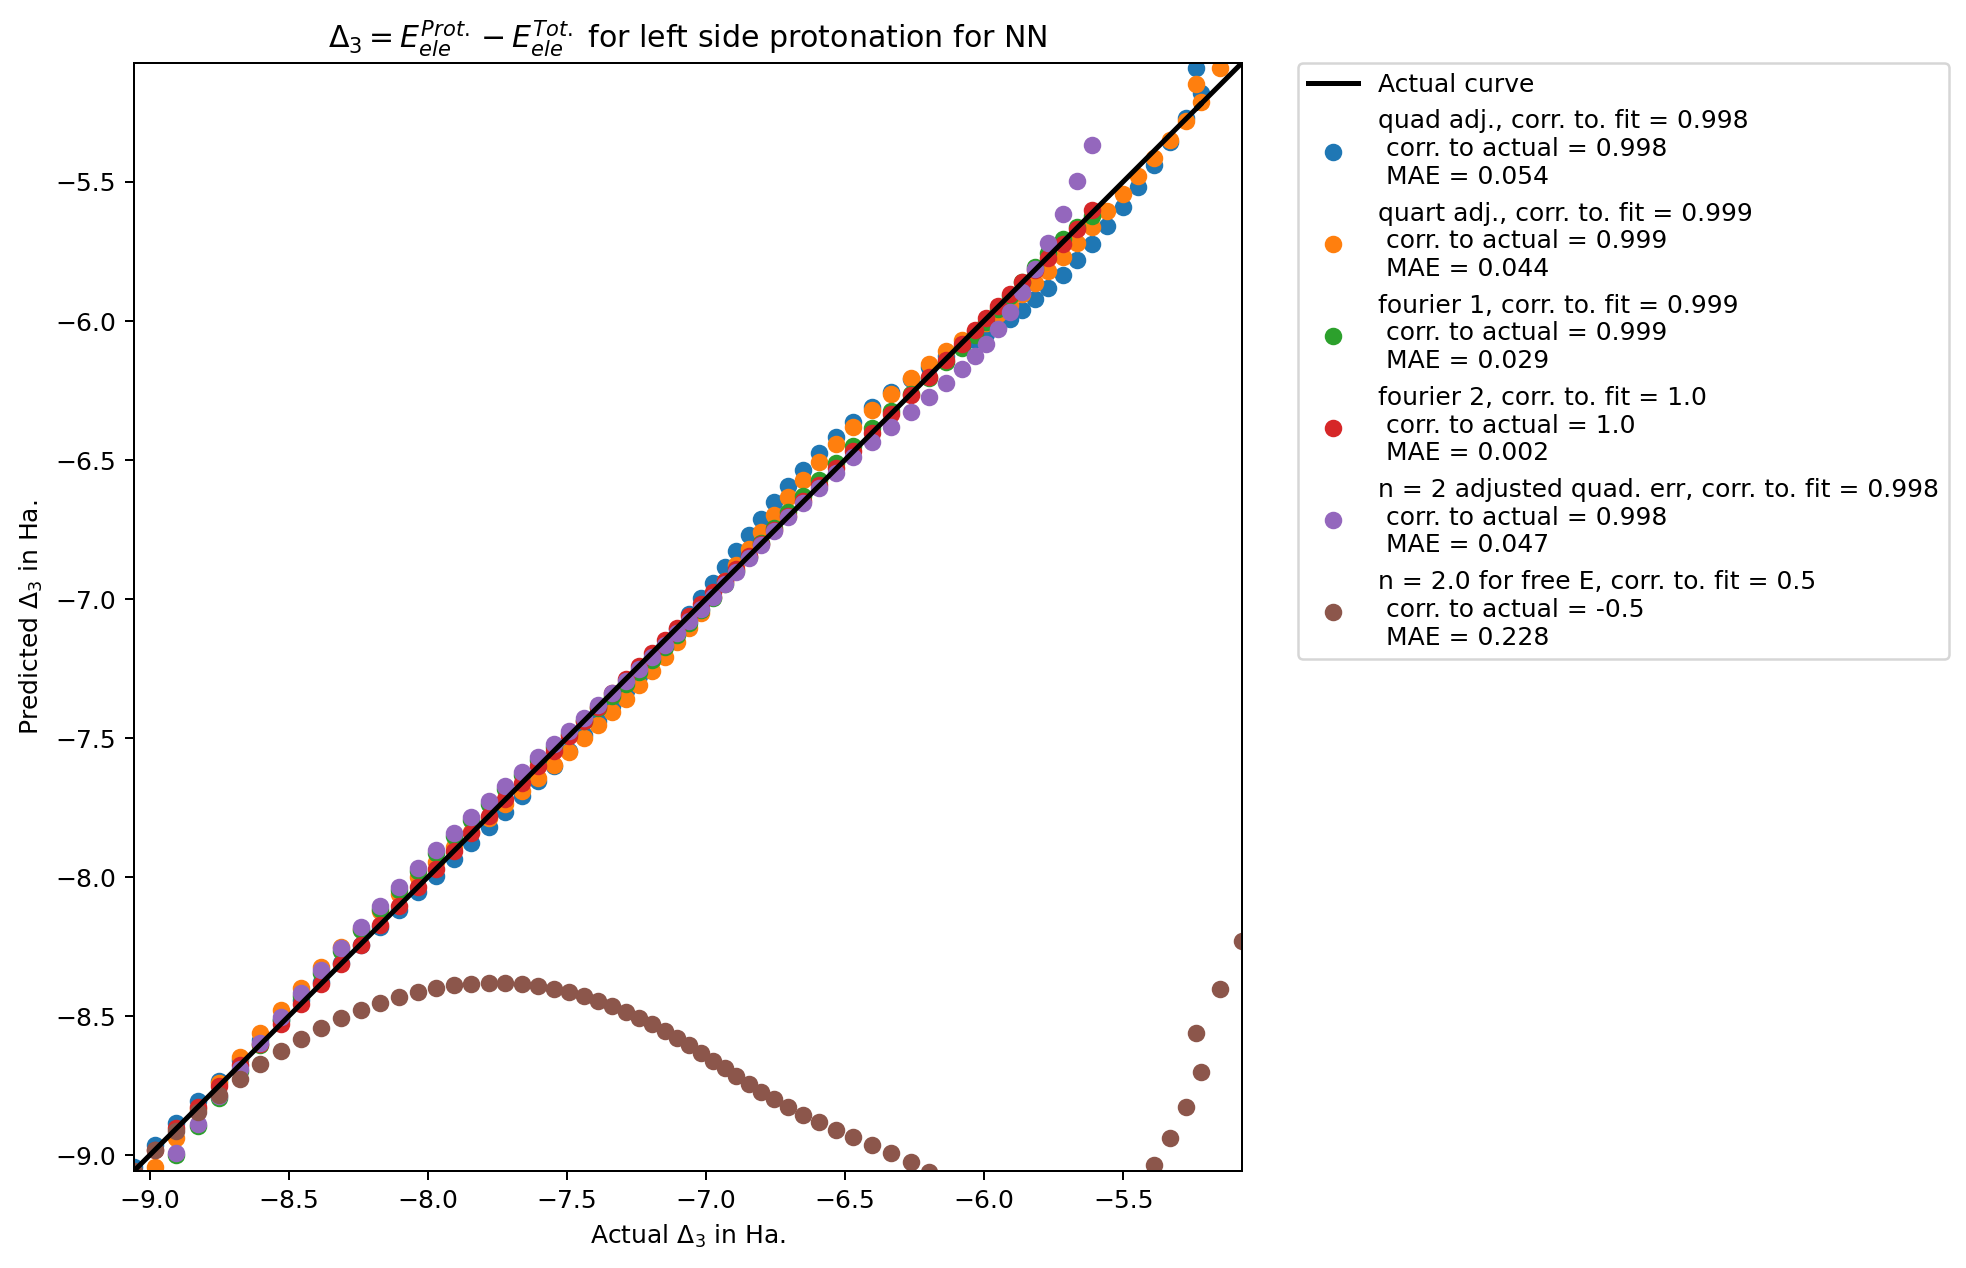

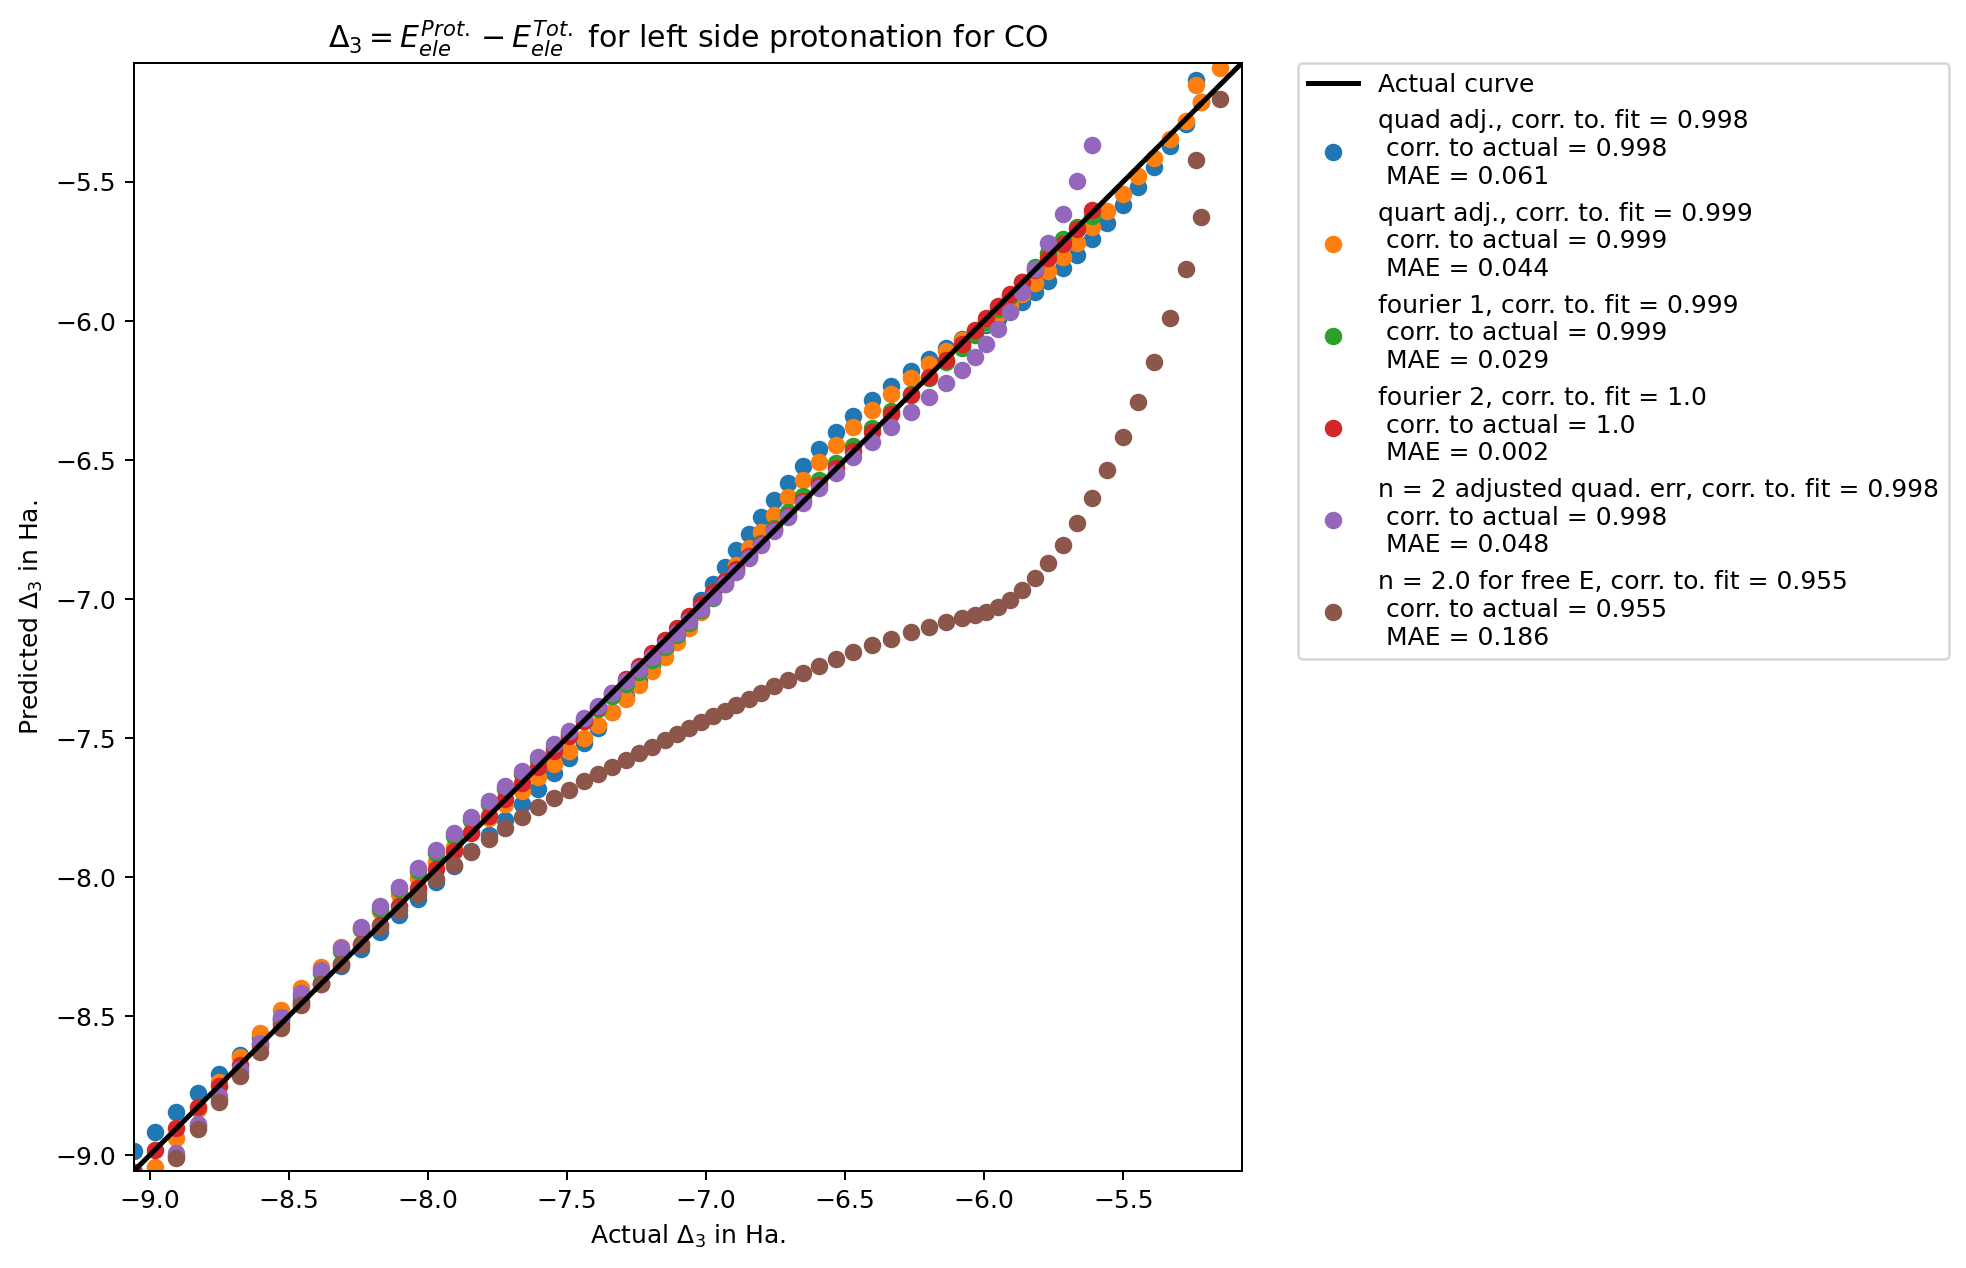

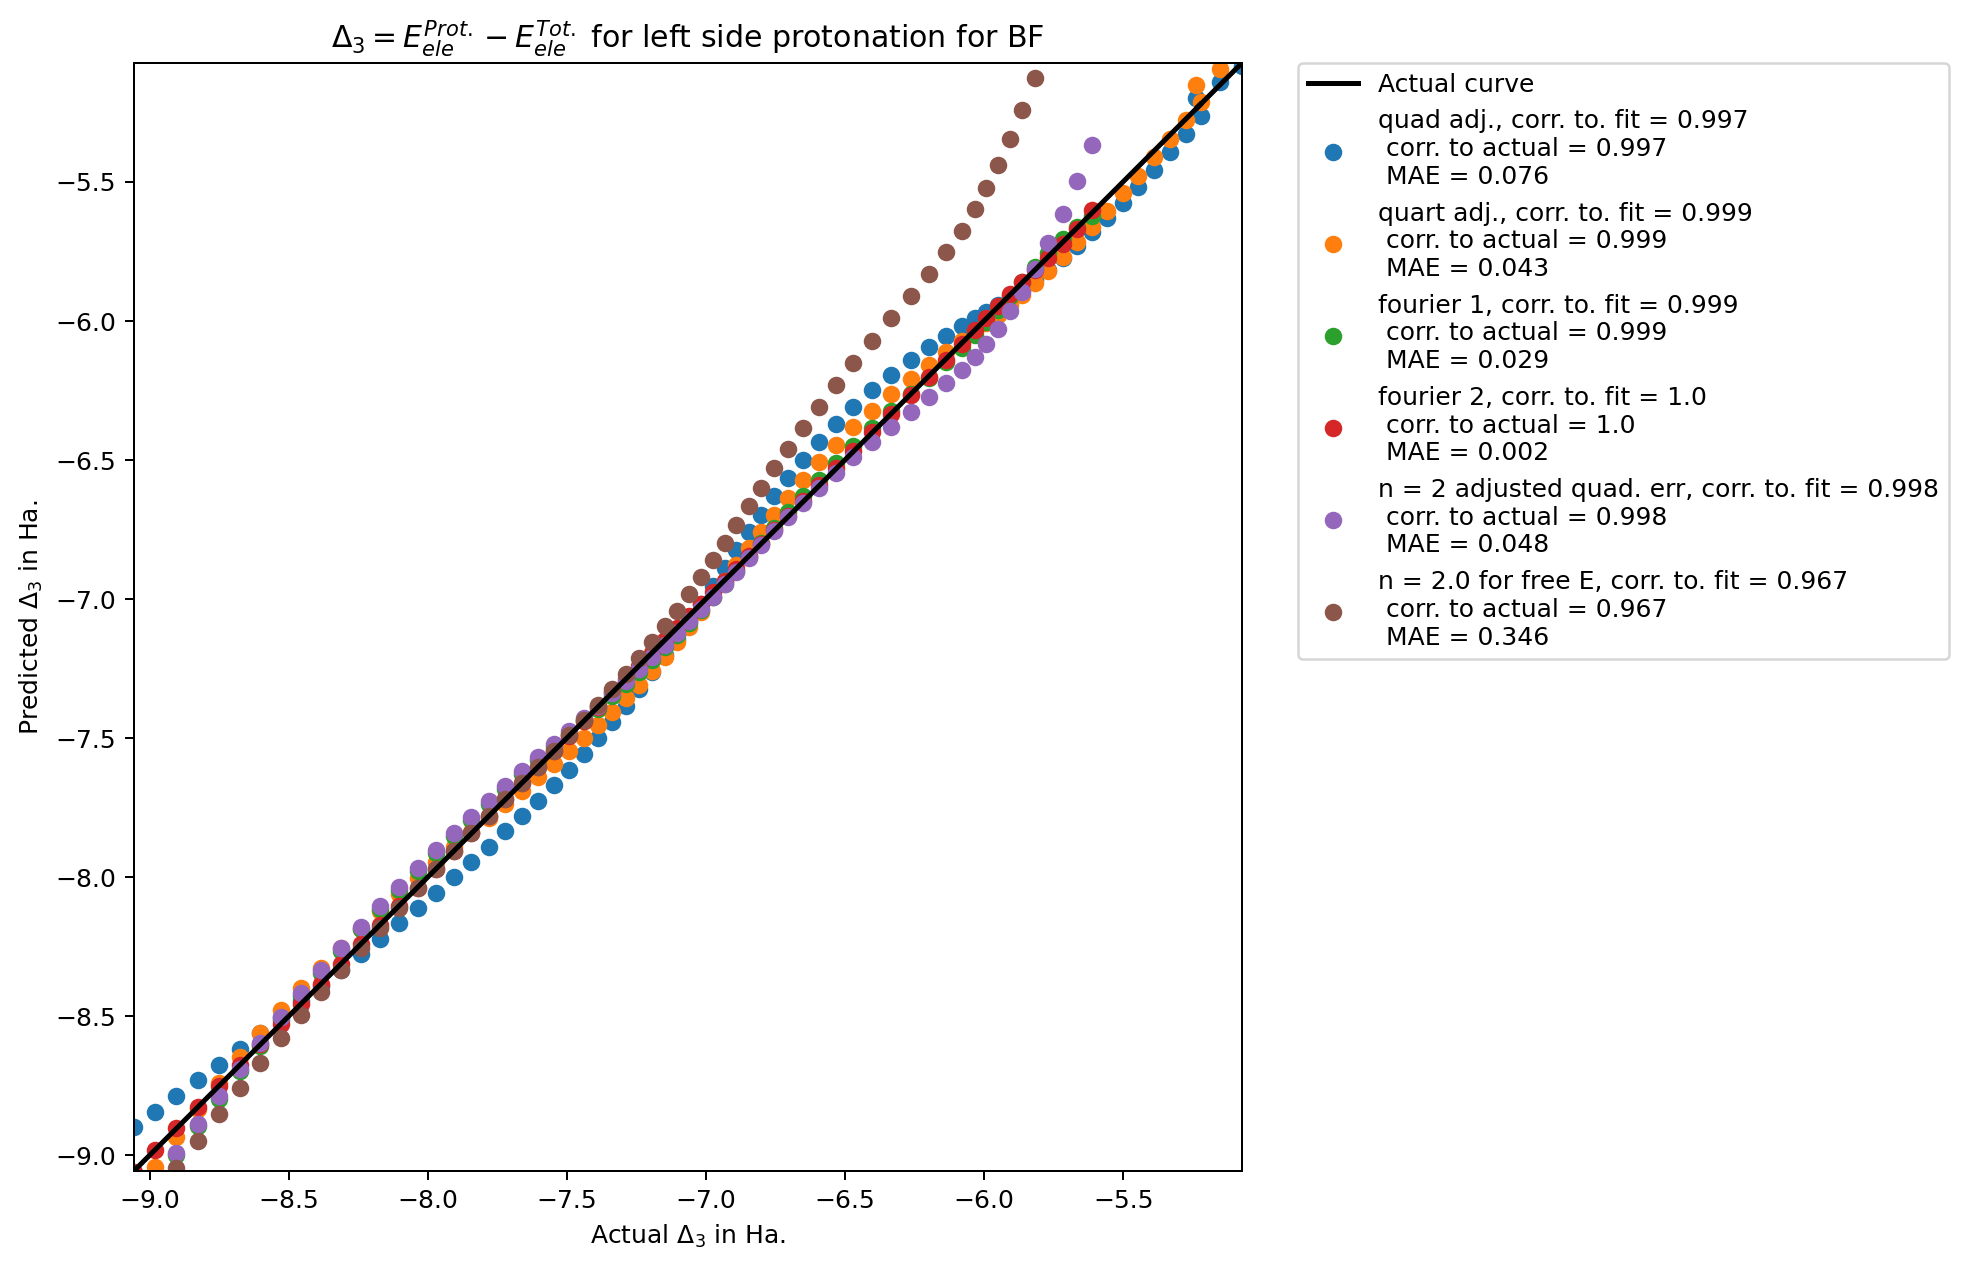

In [ ]:
'''left side'''
for i in range(3):
    figure(figsize=(8, 8), dpi=180)
    x_axis = L_P - frac_energies
    plt.plot(x_axis, L_P - frac_energies,'black',linewidth=2, label='Actual curve')
    # plt.scatter(x_axis, prediction_7_3[0]  , label='P. NN')
    for j in range(len(models)):
        if labels[j] in ['n = 2 adjusted quad. err','fourier 1', 'fourier 2']:
            xdata = x_axis[:61]
            ydata = L_P[:61] - models[j][i] 
        else:
            xdata = x_axis
            ydata = L_P - models[j][i] 
        popt, pcov = curve_fit(lin_fit, xdata, ydata,absolute_sigma=True)
        fit = np.array(lin_fit(xdata, *popt))
        fit_corr_coeff = np.corrcoef(fit, ydata)[0,1]
        ac_corr_coeff = np.corrcoef(xdata, ydata)[0,1]
         
        # plt.plot(xdata, fit)
        plt.scatter(xdata, ydata, label=labels[j]+', corr. to. fit = '\
            +str(round(fit_corr_coeff,3))+'\n corr. to actual = '+str(round(ac_corr_coeff,3))+f'\n MAE = {mae(ydata,fit):.3f}')
    # shift legend outside plots
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    # plt.legend()
    plt.axis('square')
    plt.xlim(np.min(x_axis),np.max(x_axis))
    plt.ylim(np.min(x_axis),np.max(x_axis))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlabel(r'Actual $\Delta_3$ in Ha.')
    plt.ylabel(r'Predicted $\Delta_3$ in Ha.')
    plt.title(r'$\Delta_3 = E^{Prot.}_{ele} - E^{Tot.}_{ele}$ for left side protonation for '+f'{comps[i]}')
    plt.savefig(f'../images/delta3/3_L_{comps[i]}.png')

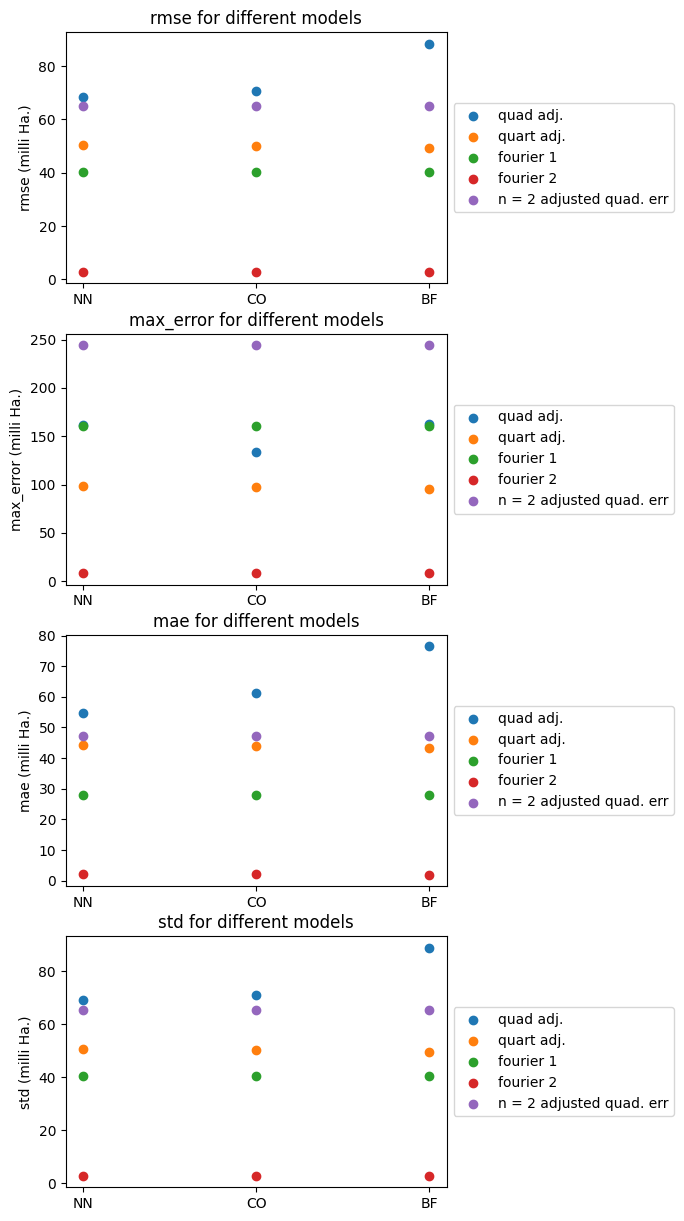

In [ ]:
'''PLotting all the errors for the different models'''
comps = ['NN', 'CO', 'BF']
error_funcs = [rmse, max_error, mae, std]
models = [quad_adjusted_prediction, \
    quart_adjusted_prediction, get_fourier_pred(1), get_fourier_pred(2), n_2_quad_adj]
labels = ['quad adj.', 'quart adj.', 'fourier 1', 'fourier 2', 'n = 2 adjusted quad. err']
all_errors = []
fig, (ax1, ax2,ax3, ax4) = plt.subplots(4,1, figsize = (15,15))
axes = [ax1, ax2, ax3, ax4]
for f in range(len(error_funcs)):
    for model in range(len(models)):
        err = []
        for i in range(3):
            if labels[model] not in ['n = 2 adjusted quad. err','fourier 1', 'fourier 2']:
                err.append(error_funcs[f](frac_energies, models[model][i]))
            else:
                err.append(error_funcs[f](frac_energies[:61], models[model][i]))
        
        # changing to milli hartree
        err = np.array(err)*1000
        axes[f].scatter(comps,err, label=f'{labels[model]}')
        axes[f].set_ylabel(f'{error_funcs[f].__name__} (milli Ha.)')
        axes[f].set_title(f'{error_funcs[f].__name__} for different models')
        # shift legend outside of plot
        box = axes[f].get_position()
        axes[f].set_position([box.x0, box.y0, box.width * 0.8, box.height])
        axes[f].legend(loc='center left', bbox_to_anchor=(1, 0.5))
                
        # axes[f].legend()

# fig.suptitle(r'Errors for different n where $Z(\lambda) = (Z_i^n + \lambda (Z_f^n-Z_i^n))^{\frac{1}{n}}$', fontsize=25)

/var/folders/qy/_rg_prqx1kn6x4b6bg336mk40000gn/T/ipykernel_58568/1176295744.py:8: RuntimeWarning: overflow encountered in exp
  return sum(A[i]*np.exp(lam*exp[i]) * np.sin(lam*f[i] + p[i]) + C[i] for i in range(len(C)))


MAE errors for 3 fourier terms (0.0005011191064878574, 0.0005417385175545576, 0.0004965187680701561)


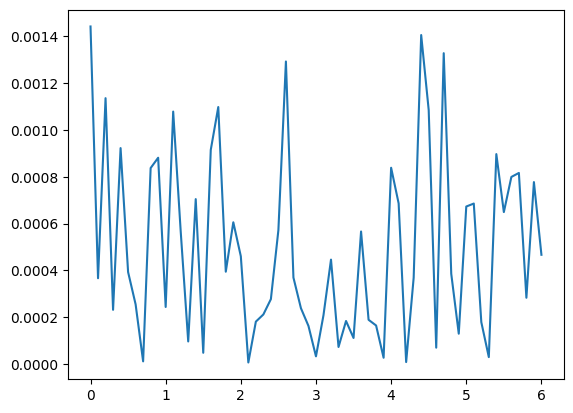

In [ ]:
x_axis = np.linspace(0,max_lam,steps + 1)
err = np.abs(frac_energies[:61] - get_fourier_pred(3)[0])
plt.plot(x_axis[:61],err)
# create numpy array of same value
print(f'MAE errors for 3 fourier terms {mae(frac_energies[:61],get_fourier_pred(3)[0]),mae(frac_energies[:61],get_fourier_pred(3)[1]),mae(frac_energies[:61],get_fourier_pred(3)[2])}')

$\lambda^b$
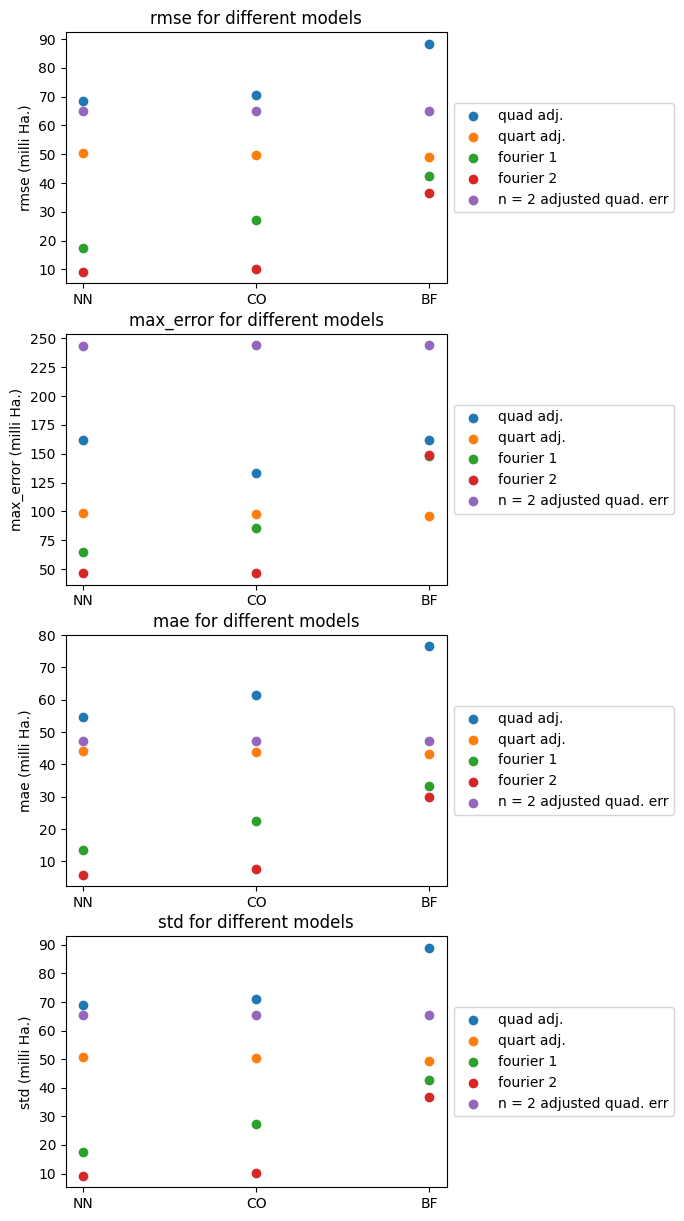

$\lambda^{lambda*b}$
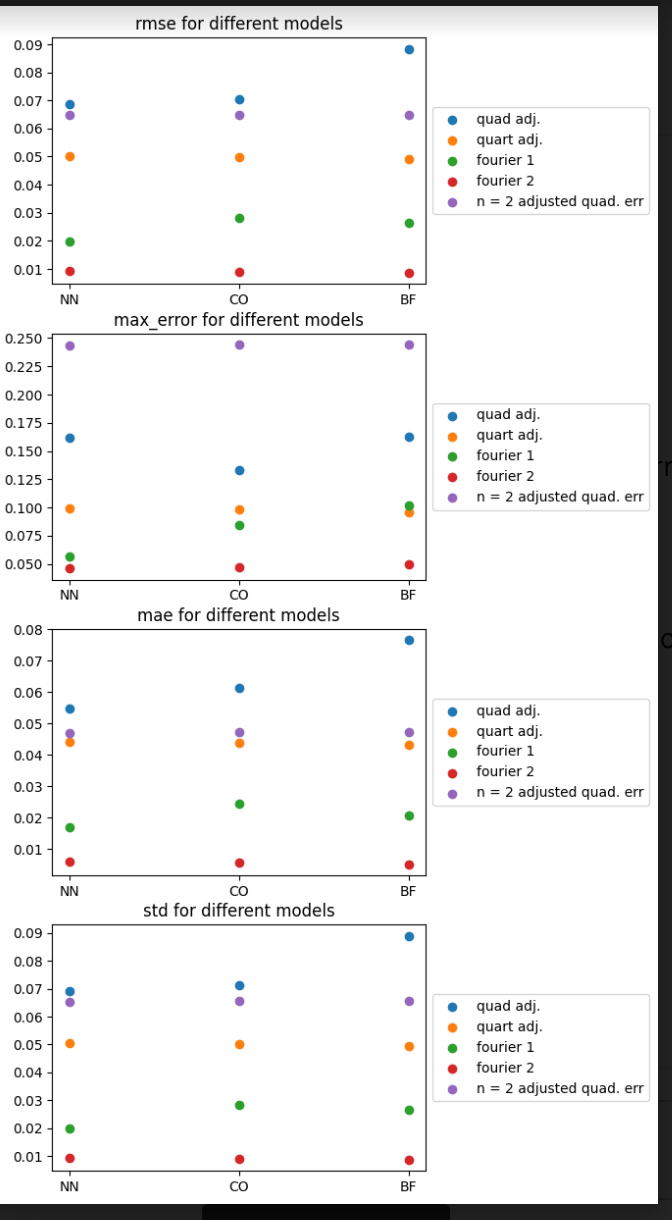

In [ ]:
plt.plot()

array([[-132.74414232, -132.78032308, -132.88165064, -133.0473191 ,
        -133.27751758, -133.5734243 , -133.93520072, -134.36098594,
        -134.85289143, -135.41099658, -136.03334493, -136.7219415 ,
        -137.47575129, -138.29469907, -139.17967053, -140.1285149 ,
        -141.14204897, -142.22106252, -143.36332499, -144.56959329,
        -145.83962053, -147.17216537, -148.56800182, -150.02692903,
        -151.5477808 , -153.1304345 , -154.77481889, -156.48192069,
        -158.24978939, -160.08054018, -161.97235469, -163.92647931,
        -165.9422212 , -168.01994168, -170.16104739, -172.36497905,
        -174.63219842, -176.96217346, -179.35636234, -181.81519669,
        -184.33806469, -186.9242945 , -189.5761387 , -192.29176045,
        -195.07122177, -197.91447466, -200.82235553, -203.79258334,
        -206.82476176, -209.9183855 , -213.07285103, -216.28747137,
        -219.56049484, -222.8911274 , -226.27755787, -229.71898551,
        -233.21464898, -236.76285586, -240.36201

for individual term exps
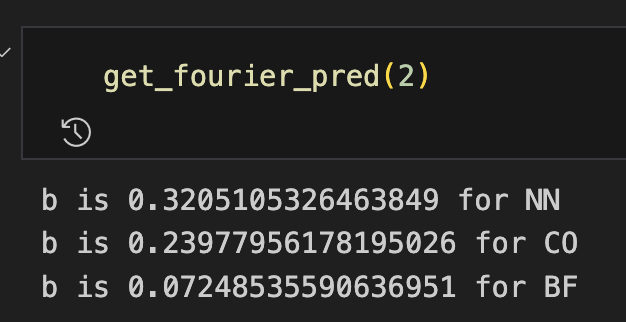